In [28]:
#Installazione pachetti 

#!pip install pandas numpy matplotlib seaborn scikit-learn xgboost requests missingno

In [29]:
#Starter Pack
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
#from matplotlib.ticker import FuncFormatter
import seaborn as sns
from scipy.stats import chi2_contingency
import requests

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
# from statsmodels.tsa.seasonal import seasonal_decompose #per serie temporali
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import plot_importance

from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve, accuracy_score, balanced_accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import os  # per interagire con il sistema operativo, eseguire operazioni sul file system e gestire variabili d'ambiente.
import warnings 
warnings.filterwarnings('ignore')

import missingno as msno
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

# Introduzione

Analizzeremo dei dati inerenti alla soddisfazione dei clienti di una compagnia aerea. Quest'ultima verrà chiamata "Compagnia x" d'ora in avanti.

La Compagnia X ci ha consegnato due file csv. Uno di "Train" e uno di "Test". Come primo passo, andremo ad approfondire questi due file csv. La denominazione può farci intendere che la compagnia si è affidato per un tempo a un data scientist.

Analizziamo innanzitutto entrambi i file.  

Per far si che questo notebook venga usufruito in qualsiasi PC, trovate nel primo blocco le librerie da installare. Faremo l'accesso ai due file csv mediante una request su una data repository in github. Per consultare il percorso cliccare su ->  https://github.com/Giofabro/exercise-data-analysis/tree/main/Data_Repository

In [30]:
# URL del file test.csv raw su GitHub
url_test_df = 'https://raw.githubusercontent.com/Giofabro/exercise-data-analysis/main/Data_Repository/ProjectDataScience_NeuralAcademy/test.csv'

# Lettura del file CSV direttamente dall'URL
test_df = pd.read_csv(url_test_df)

#URL del file train.csv raw su GitHub 
url_train_df = 'https://raw.githubusercontent.com/Giofabro/exercise-data-analysis/main/Data_Repository/ProjectDataScience_NeuralAcademy/train.csv'

# Lettura del file CSV direttamente dall'URL
train_df = pd.read_csv(url_train_df)

In [31]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25976 entries, 0 to 25975
Data columns (total 25 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Unnamed: 0                         25976 non-null  int64  
 1   id                                 25976 non-null  int64  
 2   Gender                             25976 non-null  object 
 3   Customer Type                      25976 non-null  object 
 4   Age                                25976 non-null  int64  
 5   Type of Travel                     25976 non-null  object 
 6   Class                              25976 non-null  object 
 7   Flight Distance                    25976 non-null  int64  
 8   Inflight wifi service              25976 non-null  int64  
 9   Departure/Arrival time convenient  25976 non-null  int64  
 10  Ease of Online booking             25976 non-null  int64  
 11  Gate location                      25976 non-null  int

In [32]:
test_df.isnull().sum()

Unnamed: 0                            0
id                                    0
Gender                                0
Customer Type                         0
Age                                   0
Type of Travel                        0
Class                                 0
Flight Distance                       0
Inflight wifi service                 0
Departure/Arrival time convenient     0
Ease of Online booking                0
Gate location                         0
Food and drink                        0
Online boarding                       0
Seat comfort                          0
Inflight entertainment                0
On-board service                      0
Leg room service                      0
Baggage handling                      0
Checkin service                       0
Inflight service                      0
Cleanliness                           0
Departure Delay in Minutes            0
Arrival Delay in Minutes             83
satisfaction                          0


In [33]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 25 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Unnamed: 0                         103904 non-null  int64  
 1   id                                 103904 non-null  int64  
 2   Gender                             103904 non-null  object 
 3   Customer Type                      103904 non-null  object 
 4   Age                                103904 non-null  int64  
 5   Type of Travel                     103904 non-null  object 
 6   Class                              103904 non-null  object 
 7   Flight Distance                    103904 non-null  int64  
 8   Inflight wifi service              103904 non-null  int64  
 9   Departure/Arrival time convenient  103904 non-null  int64  
 10  Ease of Online booking             103904 non-null  int64  
 11  Gate location                      1039

In [34]:
train_df.isnull().sum()

Unnamed: 0                             0
id                                     0
Gender                                 0
Customer Type                          0
Age                                    0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Inflight wifi service                  0
Departure/Arrival time convenient      0
Ease of Online booking                 0
Gate location                          0
Food and drink                         0
Online boarding                        0
Seat comfort                           0
Inflight entertainment                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Inflight service                       0
Cleanliness                            0
Departure Delay in Minutes             0
Arrival Delay in Minutes             310
satisfaction    

## Descrizione Variabili

1. Gender: Femmina, Maschio
2. Customer Type: Cliente fedele, cliente infedele
3. Age: L'età effettiva dei passeggeri
4. Type of Travel: Viaggio personale, Viaggio d'affari
5. Class: Business, Eco, Eco Plus
6. Flight distance: La distanza del volo di questo viaggio
7. Inflight wifi service: Livello di soddisfazione del servizio wifi a bordo (0:Non applicabile;1-5)
8. Departure/Arrival time convenient: Livello di soddisfazione della comodità dell'orario di partenza/arrivo
9. Ease of Online booking: Livello di soddisfazione della prenotazione online
10. Gate location: Livello di soddisfazione della posizione del gate
11. Food and drink: Livello di soddisfazione per cibo e bevande
12. Online boarding: Livello di soddisfazione dell'imbarco online
13. Seat comfort: Livello di soddisfazione del comfort del sedile
14. Inflight entertainment: Livello di soddisfazione dell'intrattenimento a bordo
15. On-board service: Livello di soddisfazione del servizio a bordo
16. Leg room service: Livello di soddisfazione dello spazio per le gambe
17. Baggage handling: Livello di soddisfazione della gestione dei bagagli
18. Check-in service: Livello di soddisfazione del servizio di check-in
19. Inflight service: Livello di soddisfazione del servizio a bordo
20. Cleanliness: Livello di soddisfazione della pulizia
21. Departure Delay in Minutes: Minuti di ritardo alla partenza
22. Arrival Delay in Minutes: Minuti di ritardo all'arrivo
23. Satisfaction: Livello di soddisfazione(Soddisfatto, neutrale o insoddisfatto)

Poiche le colonne combaciano e sembra essere frutto di uno split, capiamo come prima cosa se questi due file sono stati configurati effettivamente come un Train e un Test, medianti le percentuali di distribuzione.

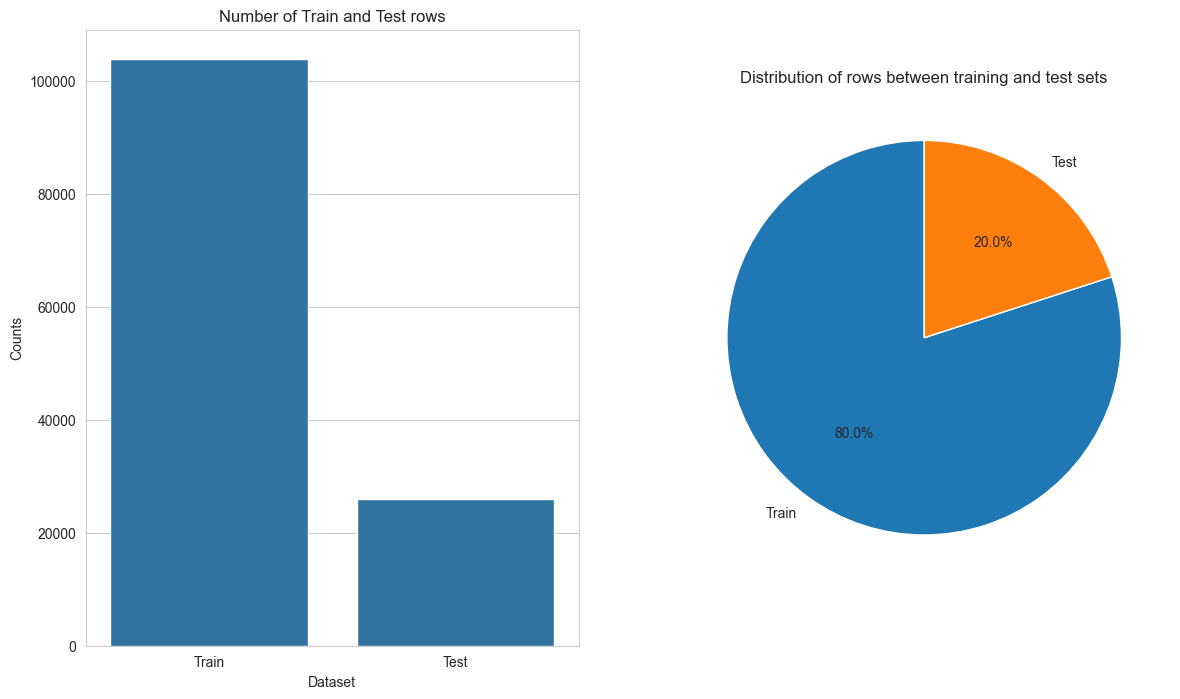

In [35]:
# Creiamo un DataFrame per i conteggi
counts_df = pd.DataFrame({
    'Dataset': ['Train', 'Test'],
    'Counts': [len(train_df), len(test_df)]
})

#Creaimo due grafici, uno a barre e uno a torta (per le percentuali)
plt.figure(figsize=(14, 8))

# Primo subplot -> grafico a barre
plt.subplot(1, 2, 1)
sns.barplot(x='Dataset', y='Counts', data=counts_df)
plt.title('Number of Train and Test rows')

# secondo plot -> grafico a torta 
labels = counts_df['Dataset']
sizes = counts_df['Counts']
plt.subplot(1, 2, 2)
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of rows between training and test sets')

plt.show()

Sì, sembra proprio un classico split 80/20. Tuttavia procediamo nel concatenare entrambi i dataframe, per avere una versione integra e completa del DataFrame ed adottare in autonomia scelte inerenti allo split di Train e di Test. E' inoltre essenziale concatenarli per procedere alla fase dell'EDA.

In [36]:
df = pd.concat([train_df, test_df])

In [37]:
df = df.drop(['Unnamed: 0', 'id'], axis=1)
df

Gender      Customer Type  Age   Type of Travel     Class  \
0        Male     Loyal Customer   13  Personal Travel  Eco Plus   
1        Male  disloyal Customer   25  Business travel  Business   
2      Female     Loyal Customer   26  Business travel  Business   
3      Female     Loyal Customer   25  Business travel  Business   
4        Male     Loyal Customer   61  Business travel  Business   
...       ...                ...  ...              ...       ...   
25971    Male  disloyal Customer   34  Business travel  Business   
25972    Male     Loyal Customer   23  Business travel  Business   
25973  Female     Loyal Customer   17  Personal Travel       Eco   
25974    Male     Loyal Customer   14  Business travel  Business   
25975  Female     Loyal Customer   42  Personal Travel       Eco   

       Flight Distance  Inflight wifi service  \
0                  460                      3   
1                  235                      3   
2                 1142                      2   
3                  562                      2   
4                  214                      3   
...                ...                    ...   
25971              526                      3   
25972              646                      4   
25973              828                      2   
25974             1127                      3   
25975              264                      2   

       Departure/Arrival time convenient  Ease of Online booking  \
0                                      4                       3   
1                                      2                       3   
2                                      2                       2   
3                                      5                       5   
4                                      3                       3   
...                                  ...                     ...   
25971                                  3                       3   
25972                                  4                       4   
25973                                  5                       1   
25974                                  3                       3   
25975                                  5                       2   

       Gate location  Food and drink  Online boarding  Seat comfort  \
0                  1               5                3             5   
1                  3               1                3             1   
2                  2               5                5             5   
3                  5               2                2             2   
4                  3               4                5             5   
...              ...             ...              ...           ...   
25971              1               4                3             4   
25972              4               4                4             4   
25973              5               2                1             2   
25974              3               4                4             4   
25975              5               4                2             2   

       Inflight entertainment  On-board service  Leg room service  \
0                           5                 4                 3   
1                           1                 1                 5   
2                           5                 4                 3   
3                           2                 2                 5   
4                           3                 3                 4   
...                       ...               ...               ...   
25971                       4                 3                 2   
25972                       4                 4                 5   
25973                       2                 4                 3   
25974                       4                 3                 2   
25975                       1                 1                 2   

       Baggage handling  Checkin service  Inflight service  Cleanliness  \
0                     4    

In [38]:
df.isnull().sum()

Gender                                 0
Customer Type                          0
Age                                    0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Inflight wifi service                  0
Departure/Arrival time convenient      0
Ease of Online booking                 0
Gate location                          0
Food and drink                         0
Online boarding                        0
Seat comfort                           0
Inflight entertainment                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Inflight service                       0
Cleanliness                            0
Departure Delay in Minutes             0
Arrival Delay in Minutes             393
satisfaction                           0
dtype: int64

Registriamo 393 valori mancanti nella colonna "Arrival Delay in minutes". Droppare queste righe non inciderà sull'integrità del nostro df (perderemo solo il 0,30% delle informazioni)

In [39]:
#Pulizia DataFrame 

df = df.drop_duplicates()
df = df.dropna()

In [40]:
# Convertiamo la colonna 'Arrival Delay in Minutes'in INT
df['Arrival Delay in Minutes'] = df['Arrival Delay in Minutes'].astype(int)

In [41]:
#check
check_row = len(df)
check_row

129487

In [42]:
df.describe()

Age  Flight Distance  Inflight wifi service  \
count  129487.000000    129487.000000          129487.000000   
mean       39.428761      1190.210662               2.728544   
std        15.117597       997.560954               1.329235   
min         7.000000        31.000000               0.000000   
25%        27.000000       414.000000               2.000000   
50%        40.000000       844.000000               3.000000   
75%        51.000000      1744.000000               4.000000   
max        85.000000      4983.000000               5.000000   

       Departure/Arrival time convenient  Ease of Online booking  \
count                      129487.000000           129487.000000   
mean                            3.057349                2.756786   
std                             1.526787                1.401662   
min                             0.000000                0.000000   
25%                             2.000000                2.000000   
50%                             3.000000                3.000000   
75%                             4.000000                4.000000   
max                             5.000000                5.000000   

       Gate location  Food and drink  Online boarding   Seat comfort  \
count  129487.000000   129487.000000    129487.000000  129487.000000   
mean        2.976909        3.204685         3.252720       3.441589   
std         1.278506        1.329905         1.350651       1.319168   
min         0.000000        0.000000         0.000000       0.000000   
25%         2.000000        2.000000         2.000000       2.000000   
50%         3.000000        3.000000         3.000000       4.000000   
75%         4.000000        4.000000         4.000000       5.000000   
max         5.000000        5.000000         5.000000       5.000000   

       Inflight entertainment  On-board service  Leg room service  \
count           129487.000000     129487.000000     129487.000000   
mean                 3.358067          3.383204          3.351078   
std                  1.334149          1.287032          1.316132   
min                  0.000000          0.000000          0.000000   
25%                  2.000000          2.000000          2.000000   
50%                  4.000000          4.000000          4.000000   
75%                  4.000000          4.000000          4.000000   
max                  5.000000          5.000000          5.000000   

       Baggage handling  Checkin service  Inflight service    Cleanliness  \
count     129487.000000    129487.000000     129487.000000  129487.000000   
mean           3.631886         3.306239          3.642373       3.286222   
std            1.180082         1.266146          1.176614       1.313624   
min            1.000000         0.000000          0.000000       0.000000   
25%            3.000000         3.000000          3.000000       2.000000   
50%            4.000000         3.000000          4.000000       3.000000   
75%            5.000000         4.000000          5.000000       4.000000   
max            5.000000         5.000000          5.000000       5.000000   

       Departure Delay in Minutes  Arrival Delay in Minutes  
count               129487.000000             129487.000000  
mean                    14.643385                 15.091129  
std                     37.932867                 38.465650  
min                      0.000000                  0.000000  
25%                      0.000000                  0.000000  
50%                      0.000000                  0.000000  
75%                     12.000000                 13.000000  
max                   1592.000000               1584.000000

# EDA

Iniziamo con qualche plot per individuare degli insight

<Axes: xlabel='satisfaction', ylabel='count'>

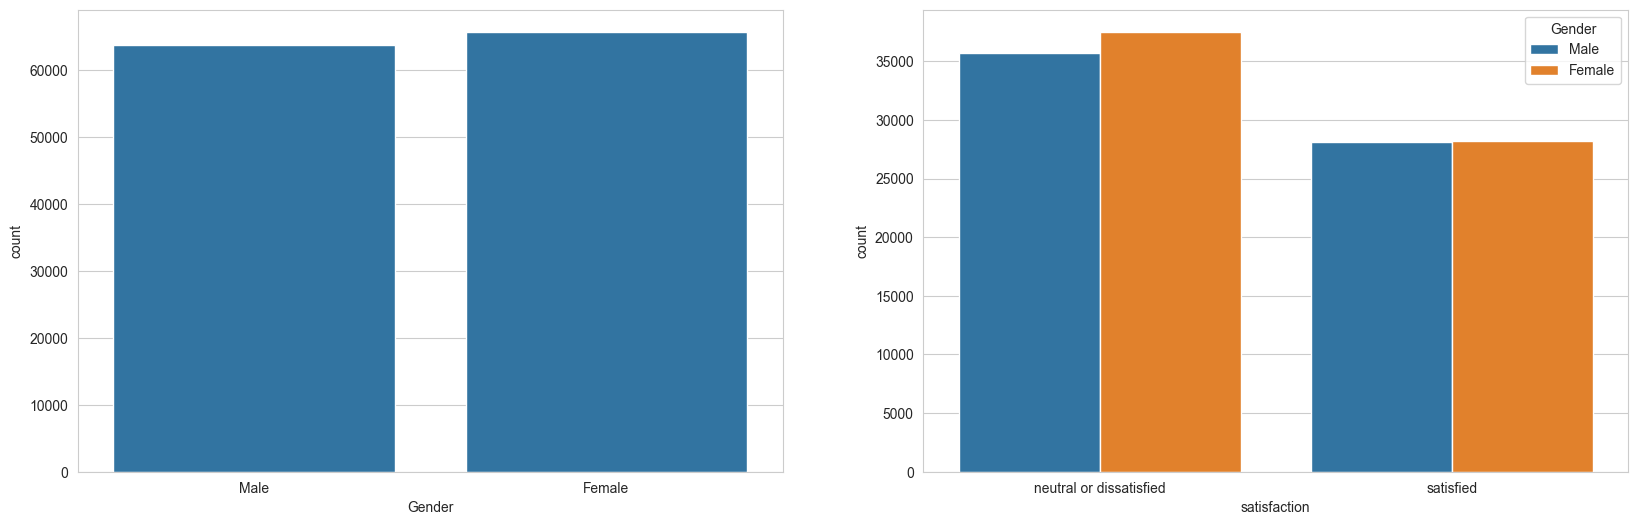

In [43]:
# Dimensioni plot e stile
plt.figure(figsize=(20, 6))
sns.set_style("whitegrid")

# Primo subplot
plt.subplot(1, 2, 1)
sns.countplot(x='Gender', data=df)

# Secondo subplot
plt.subplot(1, 2, 2)
sns.countplot(x='satisfaction', data=df, hue='Gender')

I dati mostrano una distribuzione quasi equa tra maschi e femmine. Inoltre il livello di soddisfazione non viene influenzato dal gender.

Viaggi di lunga durata potrebbero influire negativamente sulla soddisfazione. A nessuno piace stare seduto per ore.  

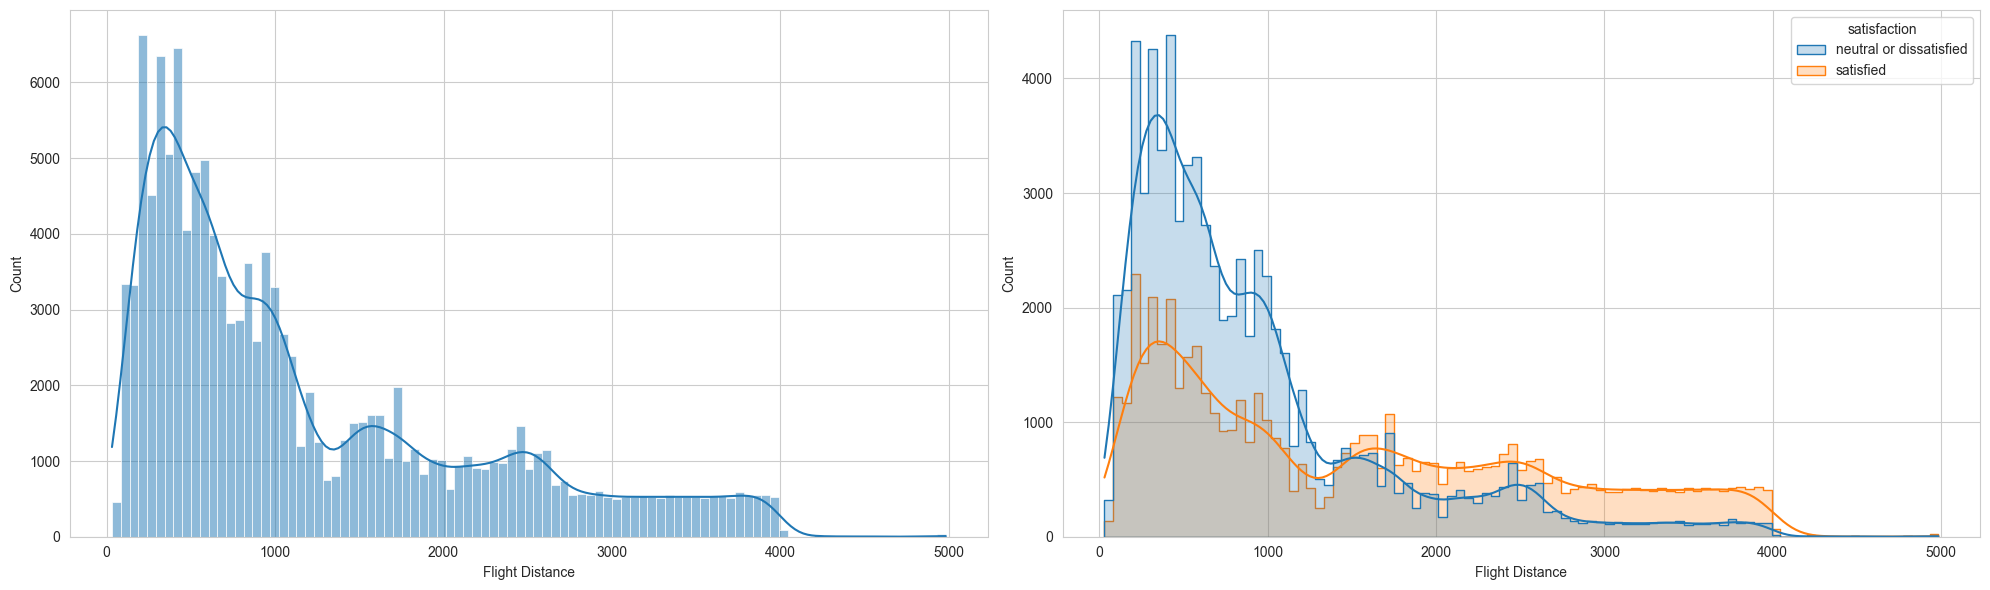

In [44]:
# Dimensioni plot e stile
plt.figure(figsize=(20, 6))
sns.set_style("whitegrid")

# Primo subplot
plt.subplot(1, 2, 1)
sns.histplot(x='Flight Distance', kde=True,  data=df)

# Secondo subplot
plt.subplot(1, 2, 2)
sns.histplot(x='Flight Distance', data=df, hue='satisfaction', kde=True, element='step')

# Visualizza il grafico
plt.tight_layout()
plt.show()

Tendenzialmente è falso. Viaggi molto lunghi tendono a portare maggior livello di soddisfazione.

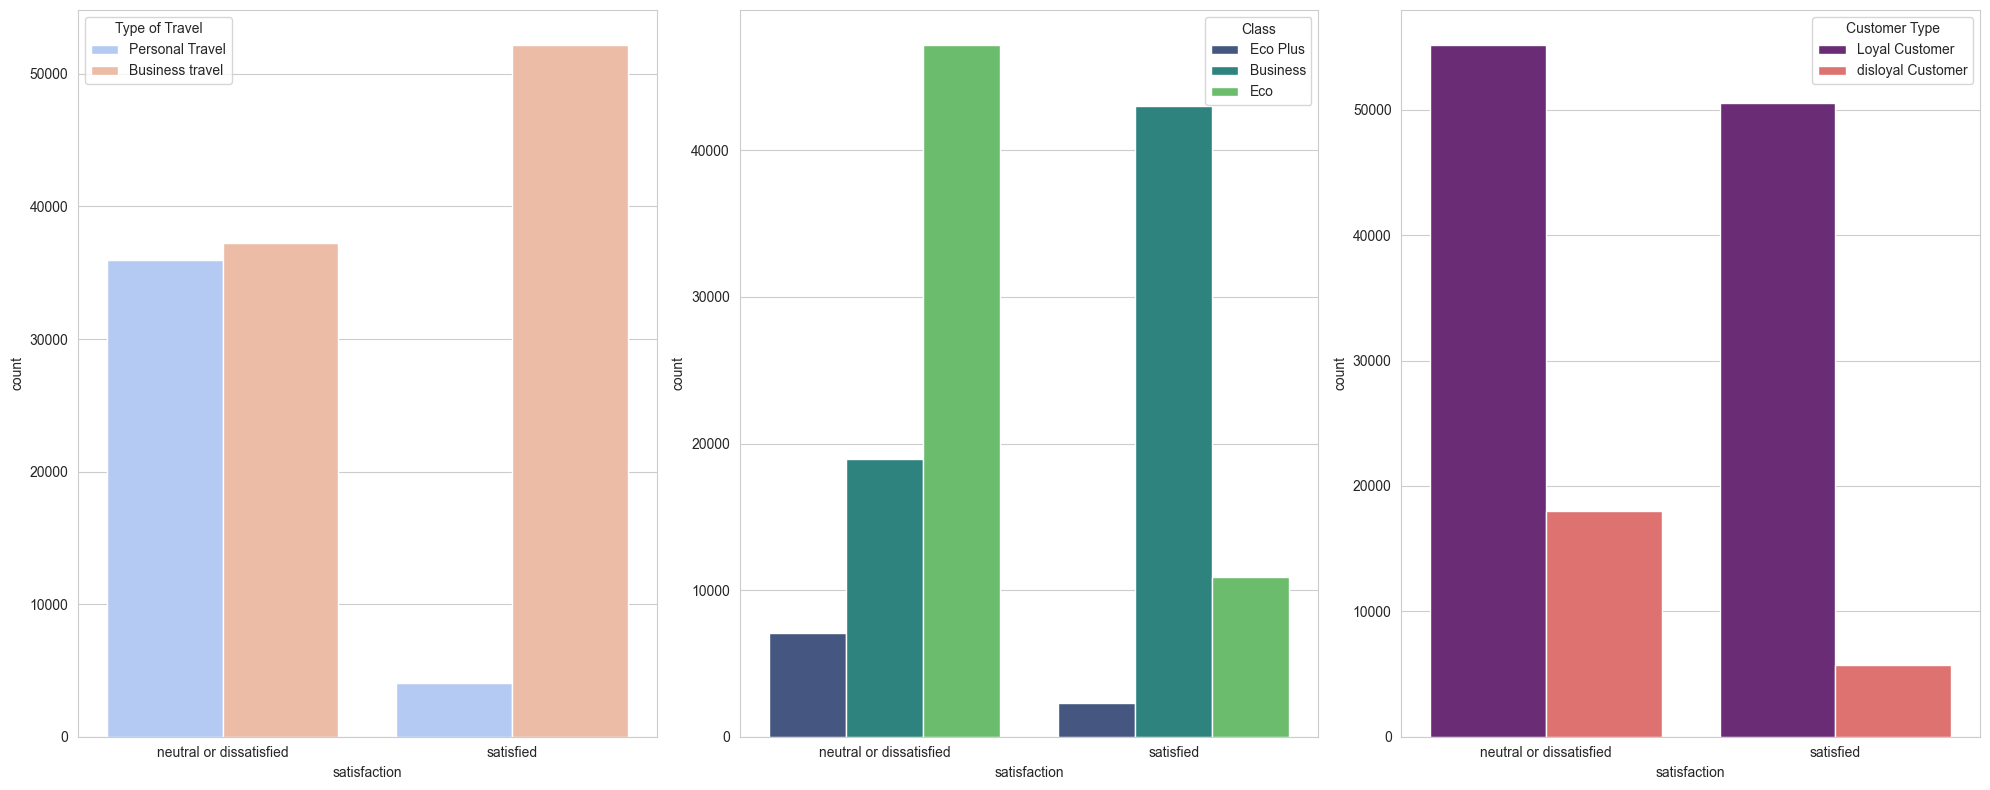

In [45]:
# Dimensioni plot e stile
plt.figure(figsize=(20, 8))
sns.set_style("whitegrid")
plt.subplots_adjust(wspace=0.5)

# Primo subplot
plt.subplot(1, 3, 1)
sns.countplot(x='satisfaction', data=df, hue='Type of Travel', palette='coolwarm')
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, title='Type of Travel', borderaxespad=0.)

# Secondo subplot
plt.subplot(1, 3, 2)
sns.countplot(x='satisfaction', data=df, hue='Class', palette='viridis')
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, title='Class', borderaxespad=0.)

# Terzo subplot
plt.subplot(1, 3, 3)
sns.countplot(x='satisfaction', data=df, hue='Customer Type', palette='magma')
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, title='Customer Type', borderaxespad=0.)

# Visualizza il grafico
plt.tight_layout()
plt.show()

Subplot 1: I viaggiatori di affari e personali si sono dichiarati similmente neutrali o insoddisfatti. Tuttavia, si può notare che tra i viaggiatori soddisfatti, i viaggi d'affari superano di gran lunga quelli personali. 

Subplot 2: C'è una distinta preferenza per la classe Business tra i passeggeri soddisfatti, seguita dalla classe Eco Plus. La classe ECo è quella che riscuote minor successo

Subplot 3: la maggior parte dei clienti soddisfatti sono clienti fedeli. Altresì anche quelli meno soddisfatti.

In [46]:
# Dimensioni plot e stile
#plt.figure(figsize=(20, 8))
#sns.set_style("whitegrid")

# Primo subplot
#plt.subplot(2, 1, 1)
#Cerchiamoci di togliere gli outlier e cocnetriamoci su un range ben specifico. 
#sns.histplot(x='Departure Delay in Minutes', data=df, hue='satisfaction', kde=True, element='step')
#plt.xlim(5, 90)  # Imposta minutaggio: da 5 minuti a un'ora e mezza di ritardo
#plt.ylim(0, 1200)

# secondo subplot
#plt.subplot(2, 1, 2)
#Cerchiamoci di togliere gli outlier e cocnetriamoci su un range ben specifico. 
#sns.histplot(x='Arrival Delay in Minutes', data=df, hue='satisfaction', kde=True, element='step')
#plt.xlim(5, 90)  # Imposta minutaggio: da 5 minuti a un'ora e mezza di ritardo
#plt.ylim(0, 1200)

# Visualizza il grafico
#plt.tight_layout()
#plt.show()

In [47]:
#sns.scatterplot(x='Departure Delay in Minutes', y='satisfaction', data=df)

Vogliamo approndire quanto il ritardo possa incidere sul livello di soddifazione, soprattutto per identificare possibili outlier 

In [48]:
# Creiamo una copia temporanea del DataFrame per il plotting
df_temp = df.copy()

# Convertiamo la colonna 'satisfaction' in valori numerici nella copia temporanea
df_temp['satisfaction'] = df_temp['satisfaction'].map({'satisfied': 1, 'neutral or dissatisfied': 0})

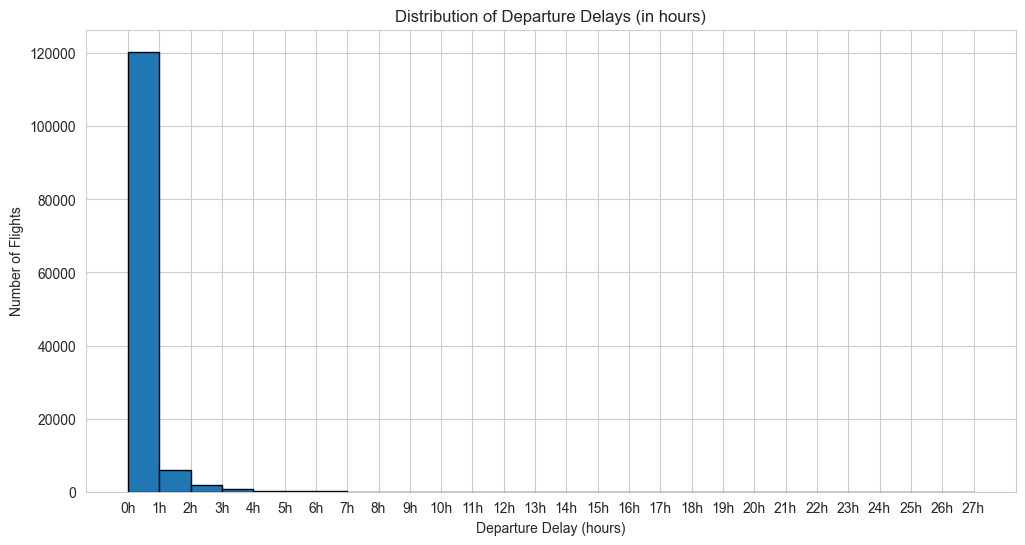

In [49]:
plt.figure(figsize=(12, 6))
bins = range(0, int(df_temp['Departure Delay in Minutes'].max()) + 61, 60)
plt.hist(df_temp['Departure Delay in Minutes'], bins=bins, edgecolor='black')

# Imposta le etichette dell'asse x in ore
hours = np.arange(0, len(bins))
plt.xticks(ticks=bins, labels=[f"{h}h" for h in hours])

plt.xlabel('Departure Delay (hours)')
plt.ylabel('Number of Flights')
plt.title('Distribution of Departure Delays (in hours)')
plt.show()

Nel contesto di un'analisi esplorativa dei dati, faremo uso della regressione logistica. La regressione logistica può essere utilizzata per esplorare la relazione tra una variabile numerica continua (come il ritardo di partenza) e una variabile dipendente binaria (come la soddisfazione). Ovviamente si tratta di una stima che fornisce una prospettiva quantitativa della correlazione tra queste variabili. La forza della regressione logistica risiede nella sua capacità di modellare decisioni binarie e fornire valutazioni probabilistiche. In questo caso, possiamo valutare come variazioni nel ritardo di partenza influenzino la probabilità di soddisfazione del cliente,

Useremo anche la regressione lineare. La regressione lineare, a differenza di quella logistica, non è limitata a restituire valori tra 0 e 1. La linea di regressione può estendersi oltre questi limiti quando cerca di minimizzare la distanza (errore) dai punti dati alla linea stessa.

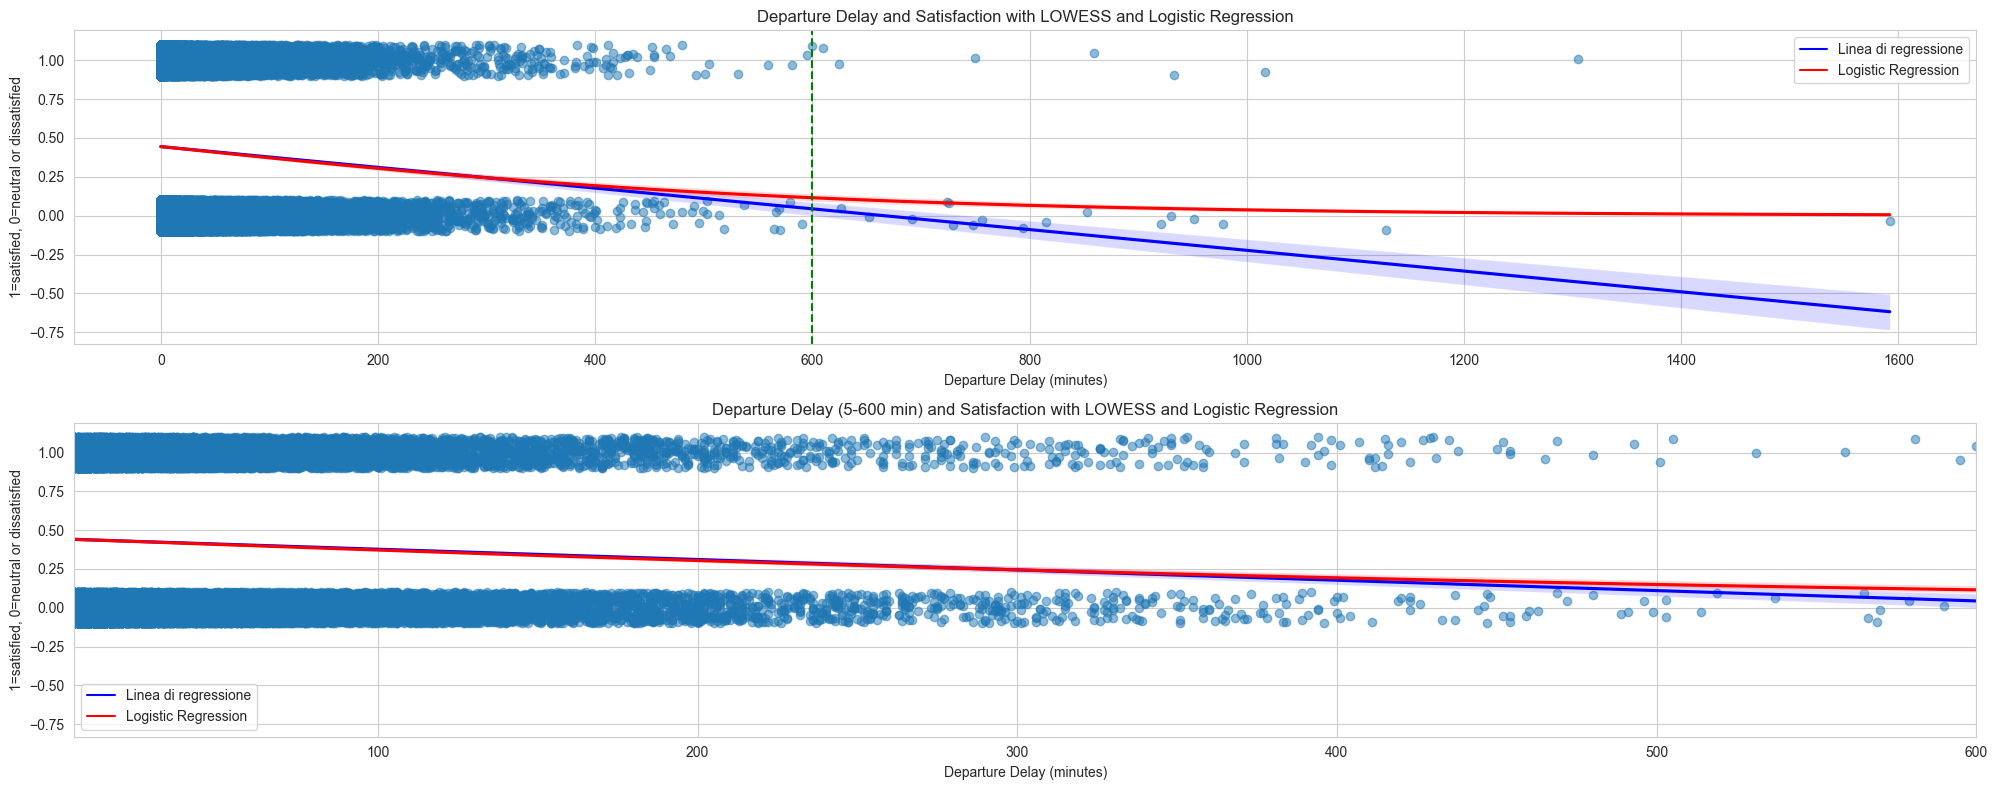

In [50]:
# Dimensioni plot e stile
plt.figure(figsize=(20, 8))
sns.set_style("whitegrid")
plt.subplots_adjust(wspace=0.5)
plt.subplots_adjust(hspace=0.5) # un po' di spazio tra il primo e il secondo plot


# Useremo l'attributo y_jitter. Senza y_jitter tutti i punti di satisfaction = 1 sarebbero esattamente allineati in orizzontale. 
# Quindi andrebbero a sovrapporsi, rendendo difficile vedere il numero effettivo di punti e la loro distribuzione lungo l'asse x. 
# Aggiungendo un po' di "y_itter" o rumore, i punti vengono leggermente spostati in alto e in basso in modo casuale, riducendo la sovrapposizione e migliorando la leggibilità.

# Primo subplot
plt.subplot(2, 1, 1)
sns.regplot(x='Departure Delay in Minutes', y='satisfaction', data=df_temp, scatter_kws={'alpha': 0.5}, line_kws={'color': 'blue'}, y_jitter=0.1)
# Regplot per il ritardo di partenza con regressione logistica
sns.regplot(x='Departure Delay in Minutes', y='satisfaction', data=df_temp, logistic=True, scatter=False, line_kws={'color': 'red'})
plt.axvline(x=600, color='green', linestyle='--')  # Linea verticale a 600 minuti
plt.title('Departure Delay and Satisfaction with LOWESS and Logistic Regression')
plt.xlabel('Departure Delay (minutes)')
plt.ylabel('1=satisfied, 0=neutral or dissatisfied')
# Aggiungere la legenda manualmente
blue_line = plt.Line2D([], [], color='blue', label='Linea di regressione')
red_line = plt.Line2D([], [], color='red', label='Logistic Regression')
green_line = plt.Line2D([], [], color='green', linestyle='--', label='10 hours')
plt.legend(handles=[blue_line, red_line])

# Secondo subplot
plt.subplot(2, 1, 2)
sns.regplot(x='Departure Delay in Minutes', y='satisfaction', data=df_temp,
            scatter_kws={'alpha': 0.5}, line_kws={'color': 'blue'}, y_jitter=0.1)
plt.xlim(5, 600)  # Imposta il limite sull'asse x da 5 a 600 minuti
# Regplot per il ritardo di partenza con regressione logistica -> focus tra 5 minuti e 600 minuti
sns.regplot(x='Departure Delay in Minutes', y='satisfaction', data=df_temp, logistic=True,
            scatter=False, line_kws={'color': 'red'})
plt.title('Departure Delay (5-600 min) and Satisfaction with LOWESS and Logistic Regression')
plt.xlabel('Departure Delay (minutes)')
plt.ylabel('1=satisfied, 0=neutral or dissatisfied')
plt.legend(handles=[blue_line, red_line])

# Visualizza il grafico
plt.tight_layout()
plt.show()

In [51]:
#Covarianza per descrivere la relazione lineare 

cov_departuredelay = np.cov(df_temp['Departure Delay in Minutes'], df_temp['satisfaction'])
print(cov_departuredelay)

# Aggiungere una linea di regressione al plot
#sns.regplot(data=df_temp, x='Departure Delay in Minutes', y='satisfaction', scatter=False, color='red')
#plt.title('Scatter Plot with Regression Line')
#plt.xlabel('Departure Delay in Minutes')
#plt.ylabel('Satisfaction')
#plt.show()

[[ 1.43890236e+03 -9.59548752e-01]
 [-9.59548752e-01  2.45711545e-01]]


1. **`1.43890236e+03`** : Questo valore è la varianza di X. La varianza è una misura di quanto i valori di X si discostano dalla media di X. Un valore elevato indica una grande dispersione dei dati.
2. **`9.59548752e-01`**: Questo valore appare due volte poiché la matrice di covarianza è simmetrica. Rappresenta la covarianza tra X e Y. La covarianza è una misura del grado in cui due variabili variano insieme. Un valore negativo indica che quando X aumenta, Y tende a diminuire e viceversa (una relazione inversa). Più il valore è lontano da zero, più forte è la relazione.
3. **`2.45711545e-01`**: Questo è la varianza di Y, che, come la varianza di X, misura quanto i valori di Y si discostano dalla media di Y.

Come abbiamo visto, dopo i 600 minuti di ritardo alla partenza, sia la regressione lineare sia la regressione logistica si appiatiscono. Stiamo analizzando questa parte perche sospettiamo ci siano dei potenziali outlier. Dopo 600 minuti, ovvero 10 ore, riteniamo che difficilmene qualcuno possa ritenersi soddisfatto dal viaggio. 

satisfaction
0    17
1     7
Name: count, dtype: int64


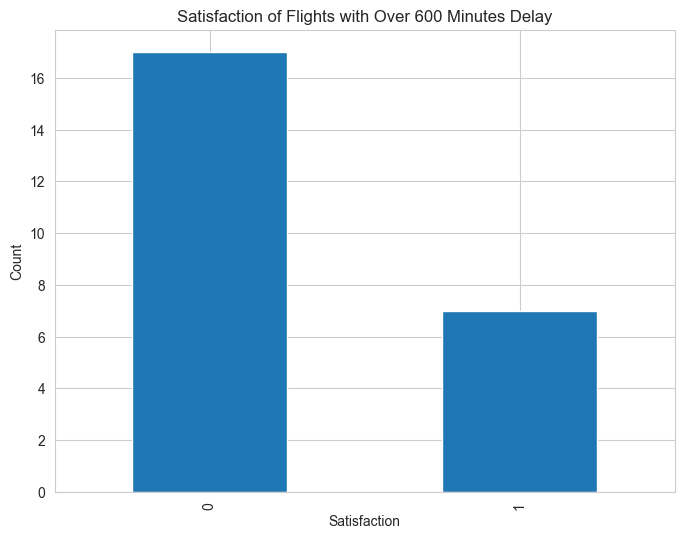

In [52]:
# Filtriamo le righe con ritardi superiori a 600 minuti
over_600_delays = df_temp[df_temp['Departure Delay in Minutes'] > 600]

# Conteggio dei valori di 'satisfaction'
satisfaction_counts_over_600 = over_600_delays['satisfaction'].value_counts()
print(satisfaction_counts_over_600)

# Creazione del grafico a barre
plt.figure(figsize=(8, 6))
satisfaction_counts_over_600.plot(kind='bar')
plt.title('Satisfaction of Flights with Over 600 Minutes Delay')
plt.xlabel('Satisfaction')
plt.ylabel('Count')
plt.show()

A nessuno piace il ritardo, ma a 7 persone a quanto pare sì. Ciò non ci convince. Potenzialmente potremmo impostare una soglia per un modello di ML. Andremmo a escludere eventualmento meno del 1% del nostro dataset. 

Nota: per ovvi motivi, departure delay e arrival delay sono fortemente correlati. Escludendo righe di uno andremo a escludere righe dell'altro.  

In [53]:
cov_departure_arrival = np.cov(df_temp['Departure Delay in Minutes'], df_temp['Arrival Delay in Minutes'])
print(cov_departure_arrival)

[[1438.90236467 1408.46831361]
 [1408.46831361 1479.6062484 ]]


Passiamo ai catplot. Mediante catplot possiamo creare grafici che mostrino la relazione tra una variabile numerica e una o più variabili categoriche. Capiamo su chi incide di più particolarmente il ritardo nelle partenze e negli arrivi. 

x="Class" significa che le categorie della classe di viaggio sono sull'asse X, mentre y="Departure Delay in Minutes" e y="Arrival Delay in Minutes" sono sull'asse Y nel primo e secondo subplot rispettivamente. Questo mostra la relazione tra la classe di viaggio e i ritardi di partenza/arrivo.

Hue: L'argomento hue="satisfaction" permette di dividere ulteriormente i dati in base al livello di soddisfazione. Questo significa che all'interno di ogni barra (per esempio, per ogni classe di viaggio), i dati sono suddivisi in base al livello di soddisfazione, rendendo possibile confrontare direttamente i gruppi di soddisfazione all'interno delle categorie.

Col: L'argomento col="Type of Travel" crea un insieme separato di grafici per ogni tipo di viaggio (es. Viaggio personale, Viaggio d'affari), consentendo di analizzare e confrontare le tendenze tra questi due gruppi in modo indipendente.

Kind: L'argomento kind="bar" specifica il tipo di grafico da creare. In questo caso, sono grafici a barre, che sono utili per confrontare quantità numeriche tra diverse categorie.

<Figure size 2000x800 with 0 Axes>

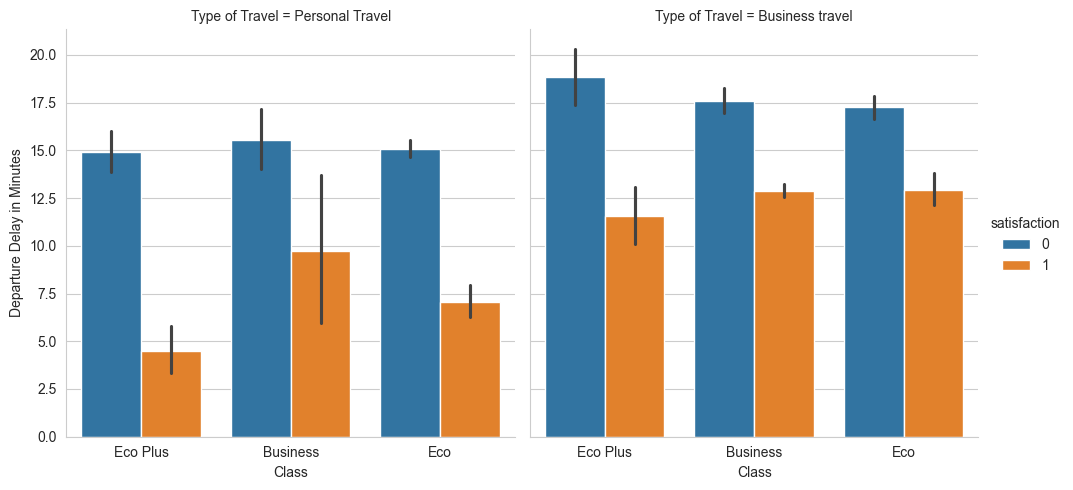

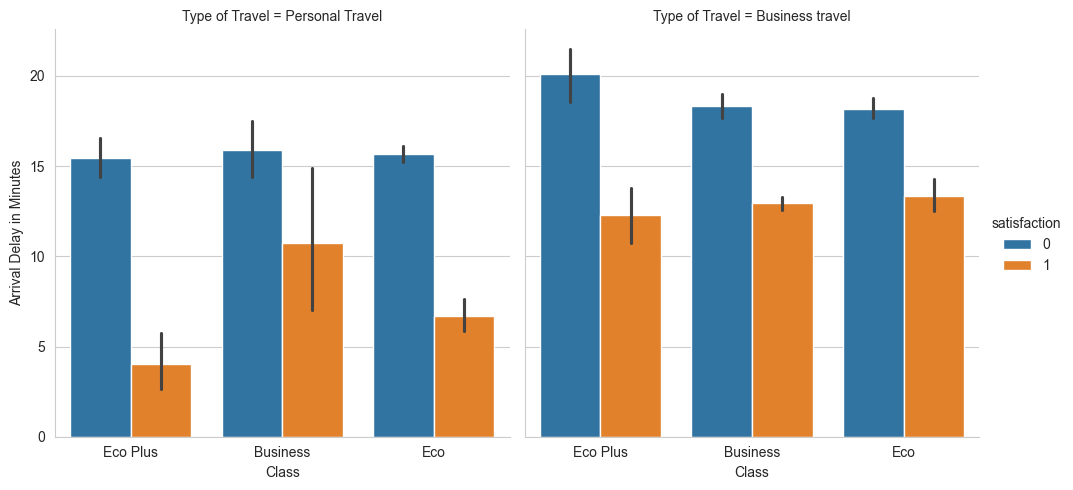

In [54]:
# Dimensioni plot e stile
plt.figure(figsize=(20, 8))
sns.set_style("whitegrid")

# Primo subplot
#plt.subplot(1, 2, 1)
sns.catplot(x="Class", y="Departure Delay in Minutes", hue="satisfaction", col="Type of Travel", data=df_temp, kind="bar")

# Secondo subplot
#plt.subplot(1, 2, 2)
sns.catplot(x="Class", y="Arrival Delay in Minutes", hue="satisfaction", col="Type of Travel", data=df_temp, kind="bar")
            
# Visualizza il grafico
#plt.tight_layout()
plt.show()

Il ritardo, ovviamente, non piace a tutti. Ma chi viaggia effettua un personal travel e viaggia in ECO plus è meno tollerante verso i ritardi degli aerei, sia in partenza sia in arrivo. Confermiamo il fatto che chi effettua business travel è più soddisfatto, non importa con quale classe viaggi.

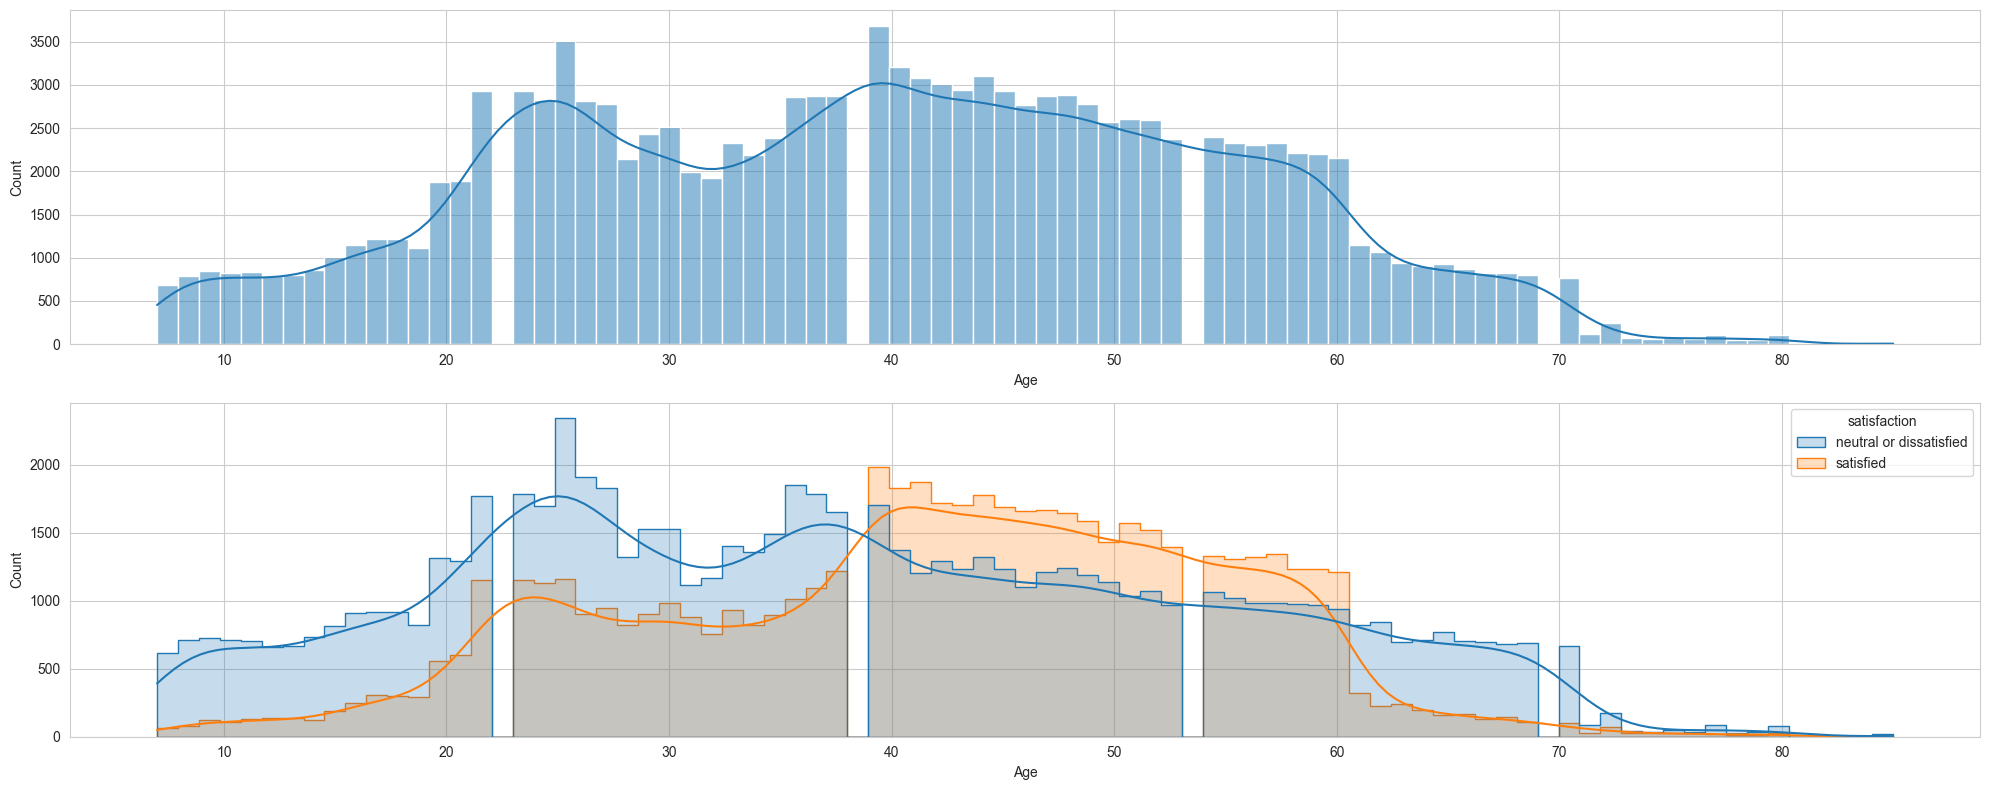

In [55]:
# Dimensioni plot e stile
plt.figure(figsize=(20, 8))
sns.set_style("whitegrid")

#First plot
plt.subplot(2,1,1)
sns.histplot(x='Age', kde=True,  data=df)

#Second subplot
plt.subplot(2,1,2)
sns.histplot(x='Age', data=df, hue='satisfaction', kde=True, element='step')

# Terzo grafico: soddisfazione per età e tipo di viaggio
#plt.subplot(3, 1, 3)  # 3 righe, 1 colonna, posizione 3
#sns.histplot(x='Age', hue='satisfaction', data=df, element='step', palette='Set2', multiple='stack', hue_order=['neutral or dissatisfied', 'satisfied'])
#sns.histplot(x='Age', hue='Type of Travel', data=df, element='step', palette='Set1', multiple='dodge', hue_order=['Personal Travel', 'Business travel'])

# Visualizza il grafico
plt.tight_layout()
plt.show()


Possiamo osservare che la maggior parte dei passeggeri ha un'età compresa tra i 20 e i 60 anni, con un picco intorno ai 40 anni. Il secondo grafico è un istogramma sovrapposto che mostra la distribuzione dell'età divisa per i livelli di soddisfazione (soddisfatti vs neutrali o insoddisfatti). Qui possiamo notare che i passeggeri soddisfatti tendono ad essere distribuiti su tutto l'arco delle età, con una leggera predominanza nella fascia di età centrale (da 30 a 50 anni). I passeggeri neutrali o insoddisfatti sembrano essere più giovani, con un picco significativo nella fascia di età 20-30 anni.

Tuttavia cerchiamo di capire come mai la fascia 40 - 50 è quella più soddisfatta. Come abbiamo visto in precedenza, chi effettua business travel è molto più soddisfatto rispetto a quelli che fanno il personal travel. Che età hanno coloro che fanno business travel?

Riprendiamo uno dei subplot precedenti, riguardo Type of Travel

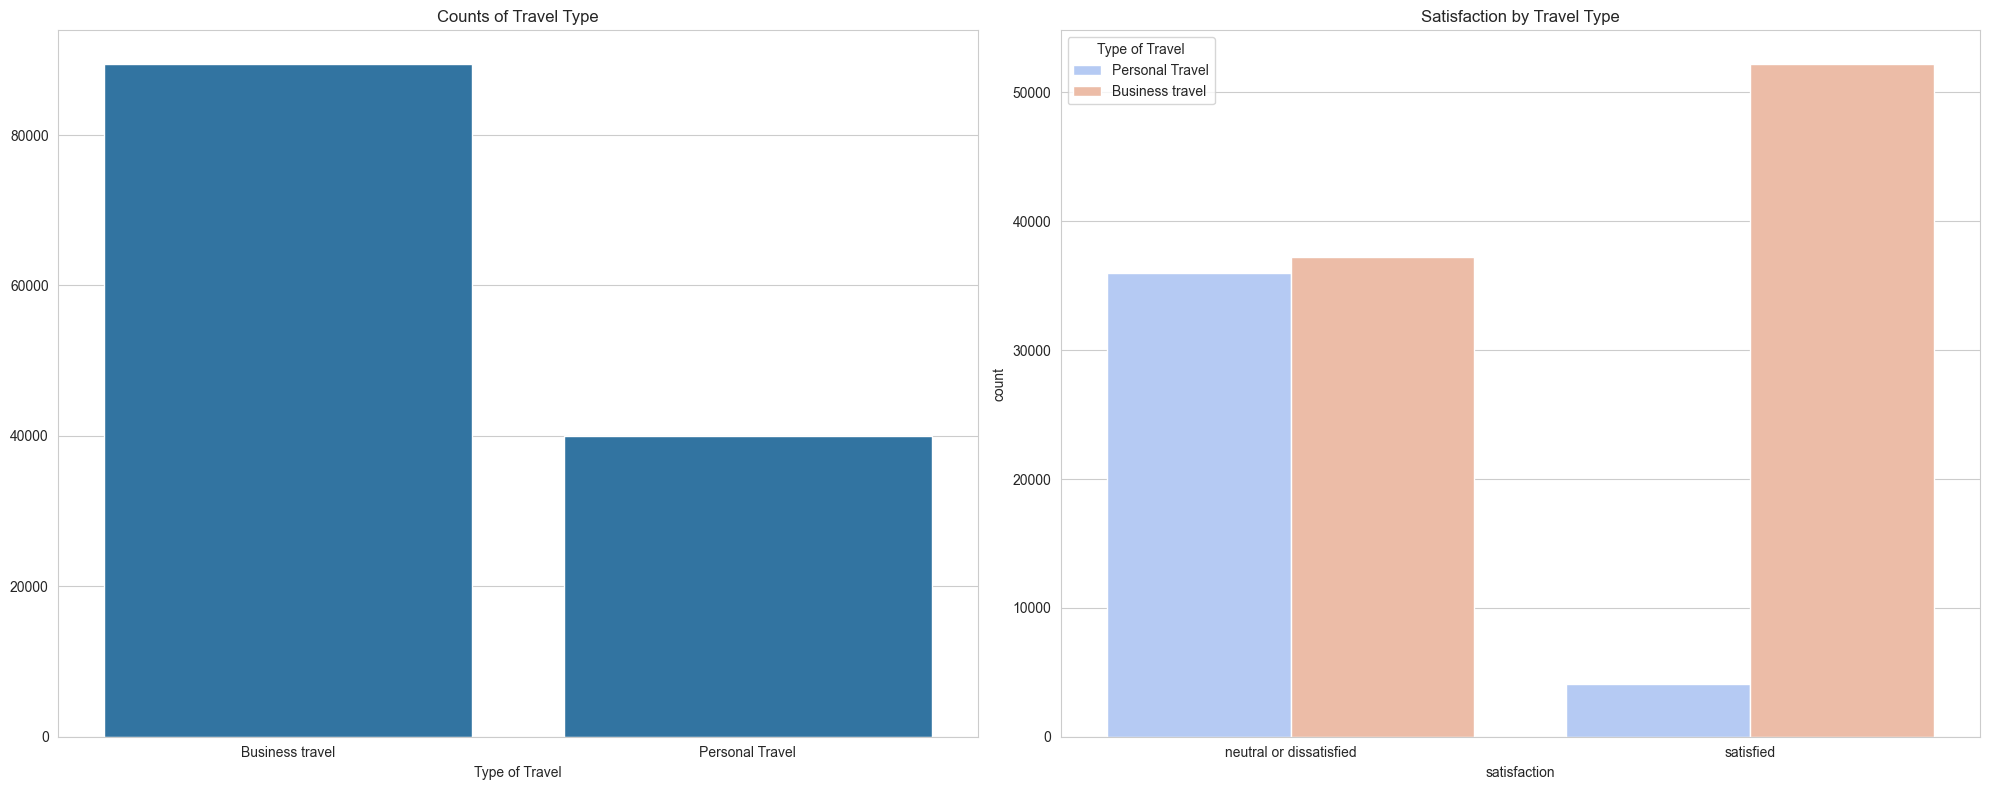

In [56]:
# Dimensioni plot e stile
plt.figure(figsize=(20, 8))
sns.set_style("whitegrid")

# Primo subplot per visualizzare il conteggio del tipo di viaggio
plt.subplot(1, 2, 1)
class_counts = df['Type of Travel'].value_counts()
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Counts of Travel Type')

# Secondo subplot per visualizzare la soddisfazione per tipo di viaggio
plt.subplot(1, 2, 2)
sns.countplot(x='satisfaction', data=df, hue='Type of Travel', palette='coolwarm')
plt.title('Satisfaction by Travel Type')

# Visualizzazione grafico
plt.tight_layout()
plt.show()

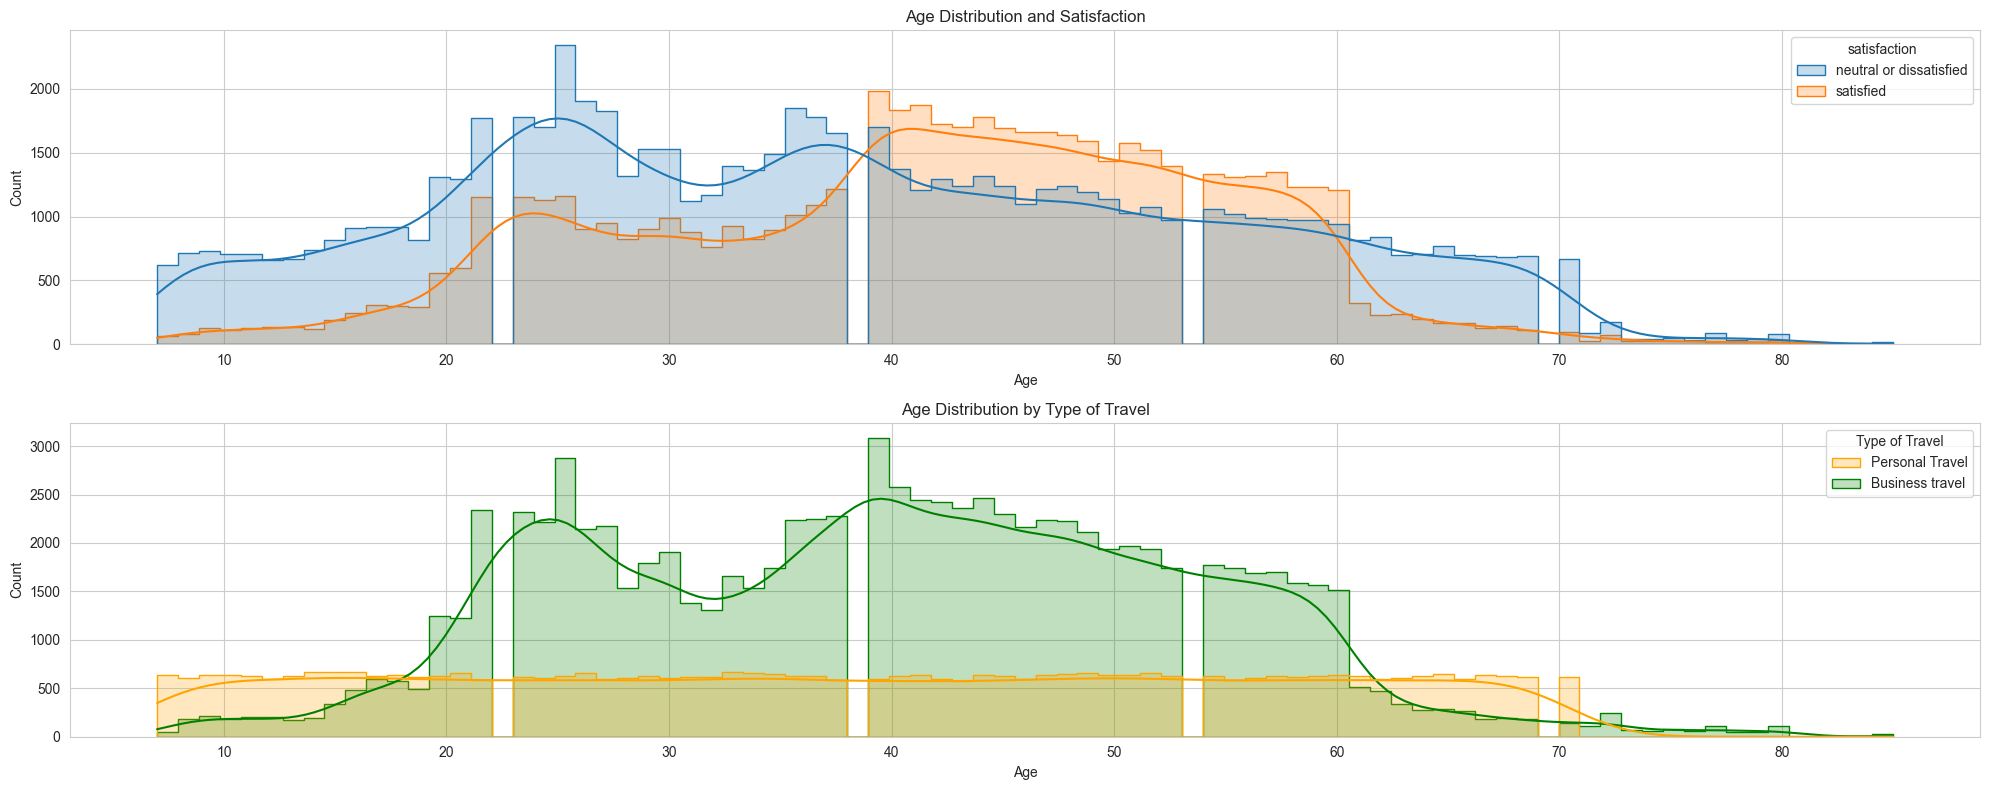

In [57]:
# Dimensioni plot e stile
plt.figure(figsize=(20, 8))
sns.set_style("whitegrid")

#First plot
plt.subplot(2,1,1)
sns.histplot(x='Age', data=df, hue='satisfaction', kde=True, element='step')
plt.title('Age Distribution and Satisfaction')

#Second subplot
plt.subplot(2,1,2)
# Definire palette di colori
palette_colors = {"Business travel": "green", "Personal Travel": "orange"}
sns.histplot(x='Age', data=df, hue='Type of Travel', kde=True, element='step', palette=palette_colors)
plt.title('Age Distribution by Type of Travel')

# Visualizza il grafico
plt.tight_layout()
plt.show()

I business travel sono la maggioranza. L'eta dei personal travels è ben distribuita su tutte le fasce di età, quelli business sulla fascia 30 - 50. Come abbiamo evidenziato, i business travels sono nettamente più soddisfatti rispetto i personal travels. Per questo nel primo istogramma vediamo una maggiore livello di soddisfazione nella fascia 40-50. 

### Crosstab & chi-quadrato [Age]

Useremo una tabella di contigenza per approfondire la relazione tra Age e Satisfaaction. Poi procederemo con il test del chi-quadrato

Con la tabella di contigenza avremo per righe l'eta dei passegeri e due colonne: "neutral or dissatisfied" e "satisfied" 

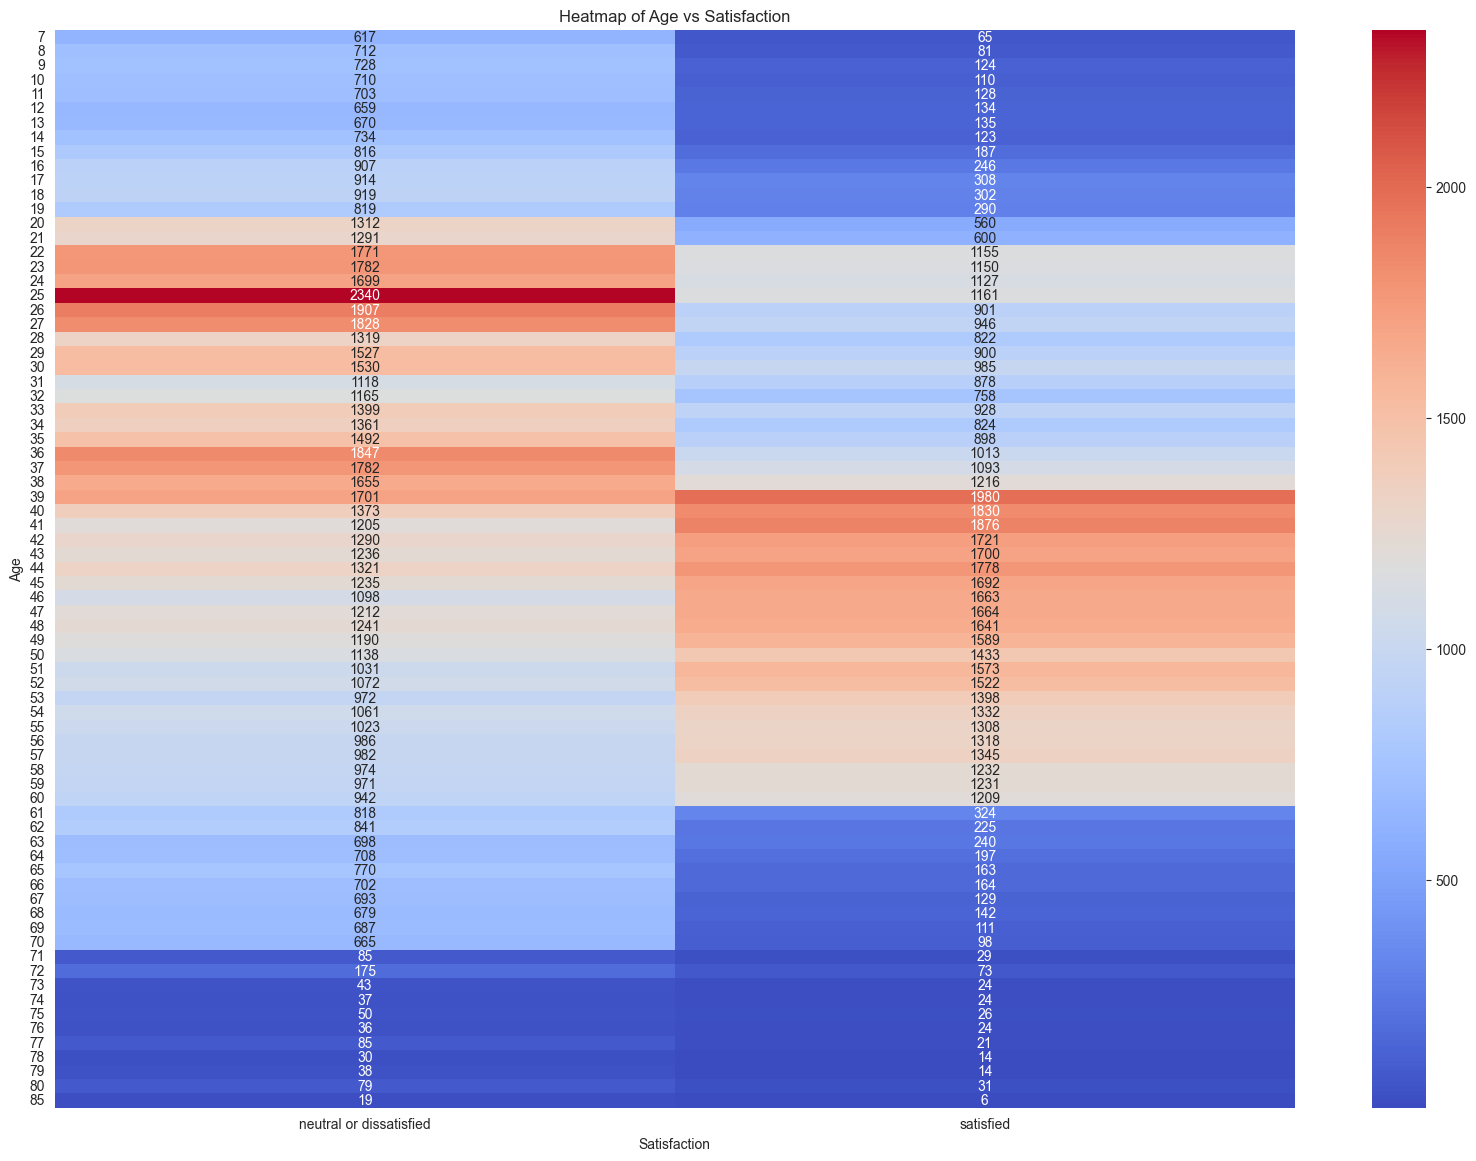

In [58]:
# Creare una Crosstab
contingency_table = pd.crosstab(df['Age'], df['satisfaction'])

# Dimensioni plot
plt.figure(figsize=(20, 14))

# Plot contingenza
sns.heatmap(contingency_table, annot=True, cmap='coolwarm', fmt='g') 
plt.title('Heatmap of Age vs Satisfaction')
plt.xlabel('Satisfaction')
plt.ylabel('Age')
plt.show()


I 25enni sono i meno soddisfatti. i 39enni i più soddisfatti.

Una volta creata la tabella di contigenza possiamo procedere al test del chi-quadrato. Il test ci indicherà chiaramente se c'è una relazione significativa tra age e satisfaction. Se il valore calcolato di chi-quadrato è maggiore del valore critico (P)

Il valore di P è un indicatore statistico che aiuta a determinare la significatività dei risultati del test. 
* Se il valore di P è minore o uguale al livello di significatività (ad esempio, 0,05), indica che i risultati del test sono statisticamente significativi. Significa che c'è una bassa probabilità che la differenza osservata sia dovuta al caso.
* Se il valore di P è maggiore del livello di significatività, suggerisce che le differenze osservate potrebbero essere dovute al caso, e quindi non si ritiene che ci sia una relazione significativa tra le variabili testate.

In [59]:
# Test del chi-quadrato
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi2 Statistic: {chi2}, p-value: {p}")

Chi2 Statistic: 11224.340874927795, p-value: 0.0


Poichè il valore P è 0, possiamo asserire che esista una relazione significativa tra l'età dei passeggeri e il loro livello di soddisfazione. 

Ciò significa che l'età è potenzialmente un fattore importante che contribuisce al grado di soddisfazione di un passeggero. Questa informazione potrebbe essere utile per la Compagnia aerea X per sviluppare strategie mirate a migliorare l'esperienza di volo per diverse fasce di età e aumentare il livello di soddisfazione complessivo dei passeggeri.

L'età potrebbe essere un buon predittore della soddisfazione in questo contesto specifico, e quindi potrebbe essere utile come caratteristica (feature) in un modello di machine learning per prevedere la soddisfazione. Tuttavia, procederemo con ulteriori analisi prima di darlo per certo. 

# Pre-processing

satisfaction
neutral or dissatisfied    73225
satisfied                  56262
Name: count, dtype: int64


<Axes: xlabel='satisfaction'>

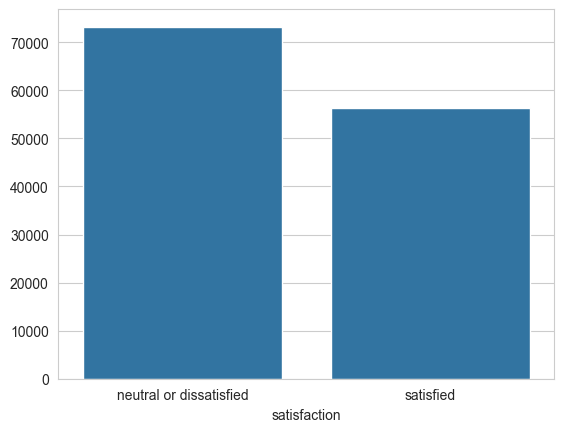

In [60]:
# Visione sulla distrubizione del target
class_counts = df['satisfaction'].value_counts()
print(class_counts)

sns.barplot(x=class_counts.index, y=class_counts.values)

Target ben distribuito. 

Procederemo aggiornando il nostro df, togliendo i dati che registrano più di 600 minuti di ritardo.

In [61]:
# togliamo le righe che hanno valori oltre 600 minuti in Departure Delay in Minutes
df = df[df['Departure Delay in Minutes'] < 600]

## Label Encoding

In [62]:
#Label encoding 
satisfaction_mapping = {"satisfied": 1, "neutral or dissatisfied": 0}
df['satisfaction'] = df['satisfaction'].map(satisfaction_mapping) 

## Gender column - label encoding  
gender_mapping = {"Female": 1, "Male": 0}
df['Gender'] = df['Gender'].map(gender_mapping) 

## Customer type column - label encoding  
customer_type_mapping = {"Loyal Customer": 1, "disloyal Customer": 0}
df['Customer Type'] = df['Customer Type'].map(customer_type_mapping) 

## Type of travel column - label encoding  
travel_type_mapping = {"Business travel": 1, "Personal Travel": 0}
df['Type of Travel'] = df['Type of Travel'].map(travel_type_mapping)  

## Class column - label encoding  
class_mapping = {"Business": 3, "Eco Plus": 2, "Eco": 1}
df['Class'] = df['Class'].map(class_mapping)  

In [63]:
df

Gender  Customer Type  Age  Type of Travel  Class  Flight Distance  \
0           0              1   13               0      2              460   
1           0              0   25               1      3              235   
2           1              1   26               1      3             1142   
3           1              1   25               1      3              562   
4           0              1   61               1      3              214   
...       ...            ...  ...             ...    ...              ...   
25971       0              0   34               1      3              526   
25972       0              1   23               1      3              646   
25973       1              1   17               0      1              828   
25974       0              1   14               1      3             1127   
25975       1              1   42               0      1              264   

       Inflight wifi service  Departure/Arrival time convenient  \
0                          3                                  4   
1                          3                                  2   
2                          2                                  2   
3                          2                                  5   
4                          3                                  3   
...                      ...                                ...   
25971                      3                                  3   
25972                      4                                  4   
25973                      2                                  5   
25974                      3                                  3   
25975                      2                                  5   

       Ease of Online booking  Gate location  Food and drink  Online boarding  \
0                           3              1               5                3   
1                           3              3               1                3   
2                           2              2               5                5   
3                           5              5               2                2   
4                           3              3               4                5   
...                       ...            ...             ...              ...   
25971                       3              1               4                3   
25972                       4              4               4                4   
25973                       1              5               2                1   
25974                       3              3               4                4   
25975                       2              5               4                2   

       Seat comfort  Inflight entertainment  On-board service  \
0                 5                       5                 4   
1                 1                       1                 1   
2                 5                       5                 4   
3                 2                       2                 2   
4                 5                       3                 3   
...             ...                     ...               ...   
25971             4                       4                 3   
25972             4                       4                 4   
25973             2                       2                 4   
25974             4                       4                 3   
25975             2                       1                 1   

       Leg room service  Baggage handling  Checkin service  Inflight service  \
0                     3                 4                4                 5   
1                     5                 3                1                 4   
2                     3                 4                4                 4   
3                     5                 3                1                 4   
4                     4                 4                3                 3   
...                 ...               ...  

## Features selection -> correlazioni  

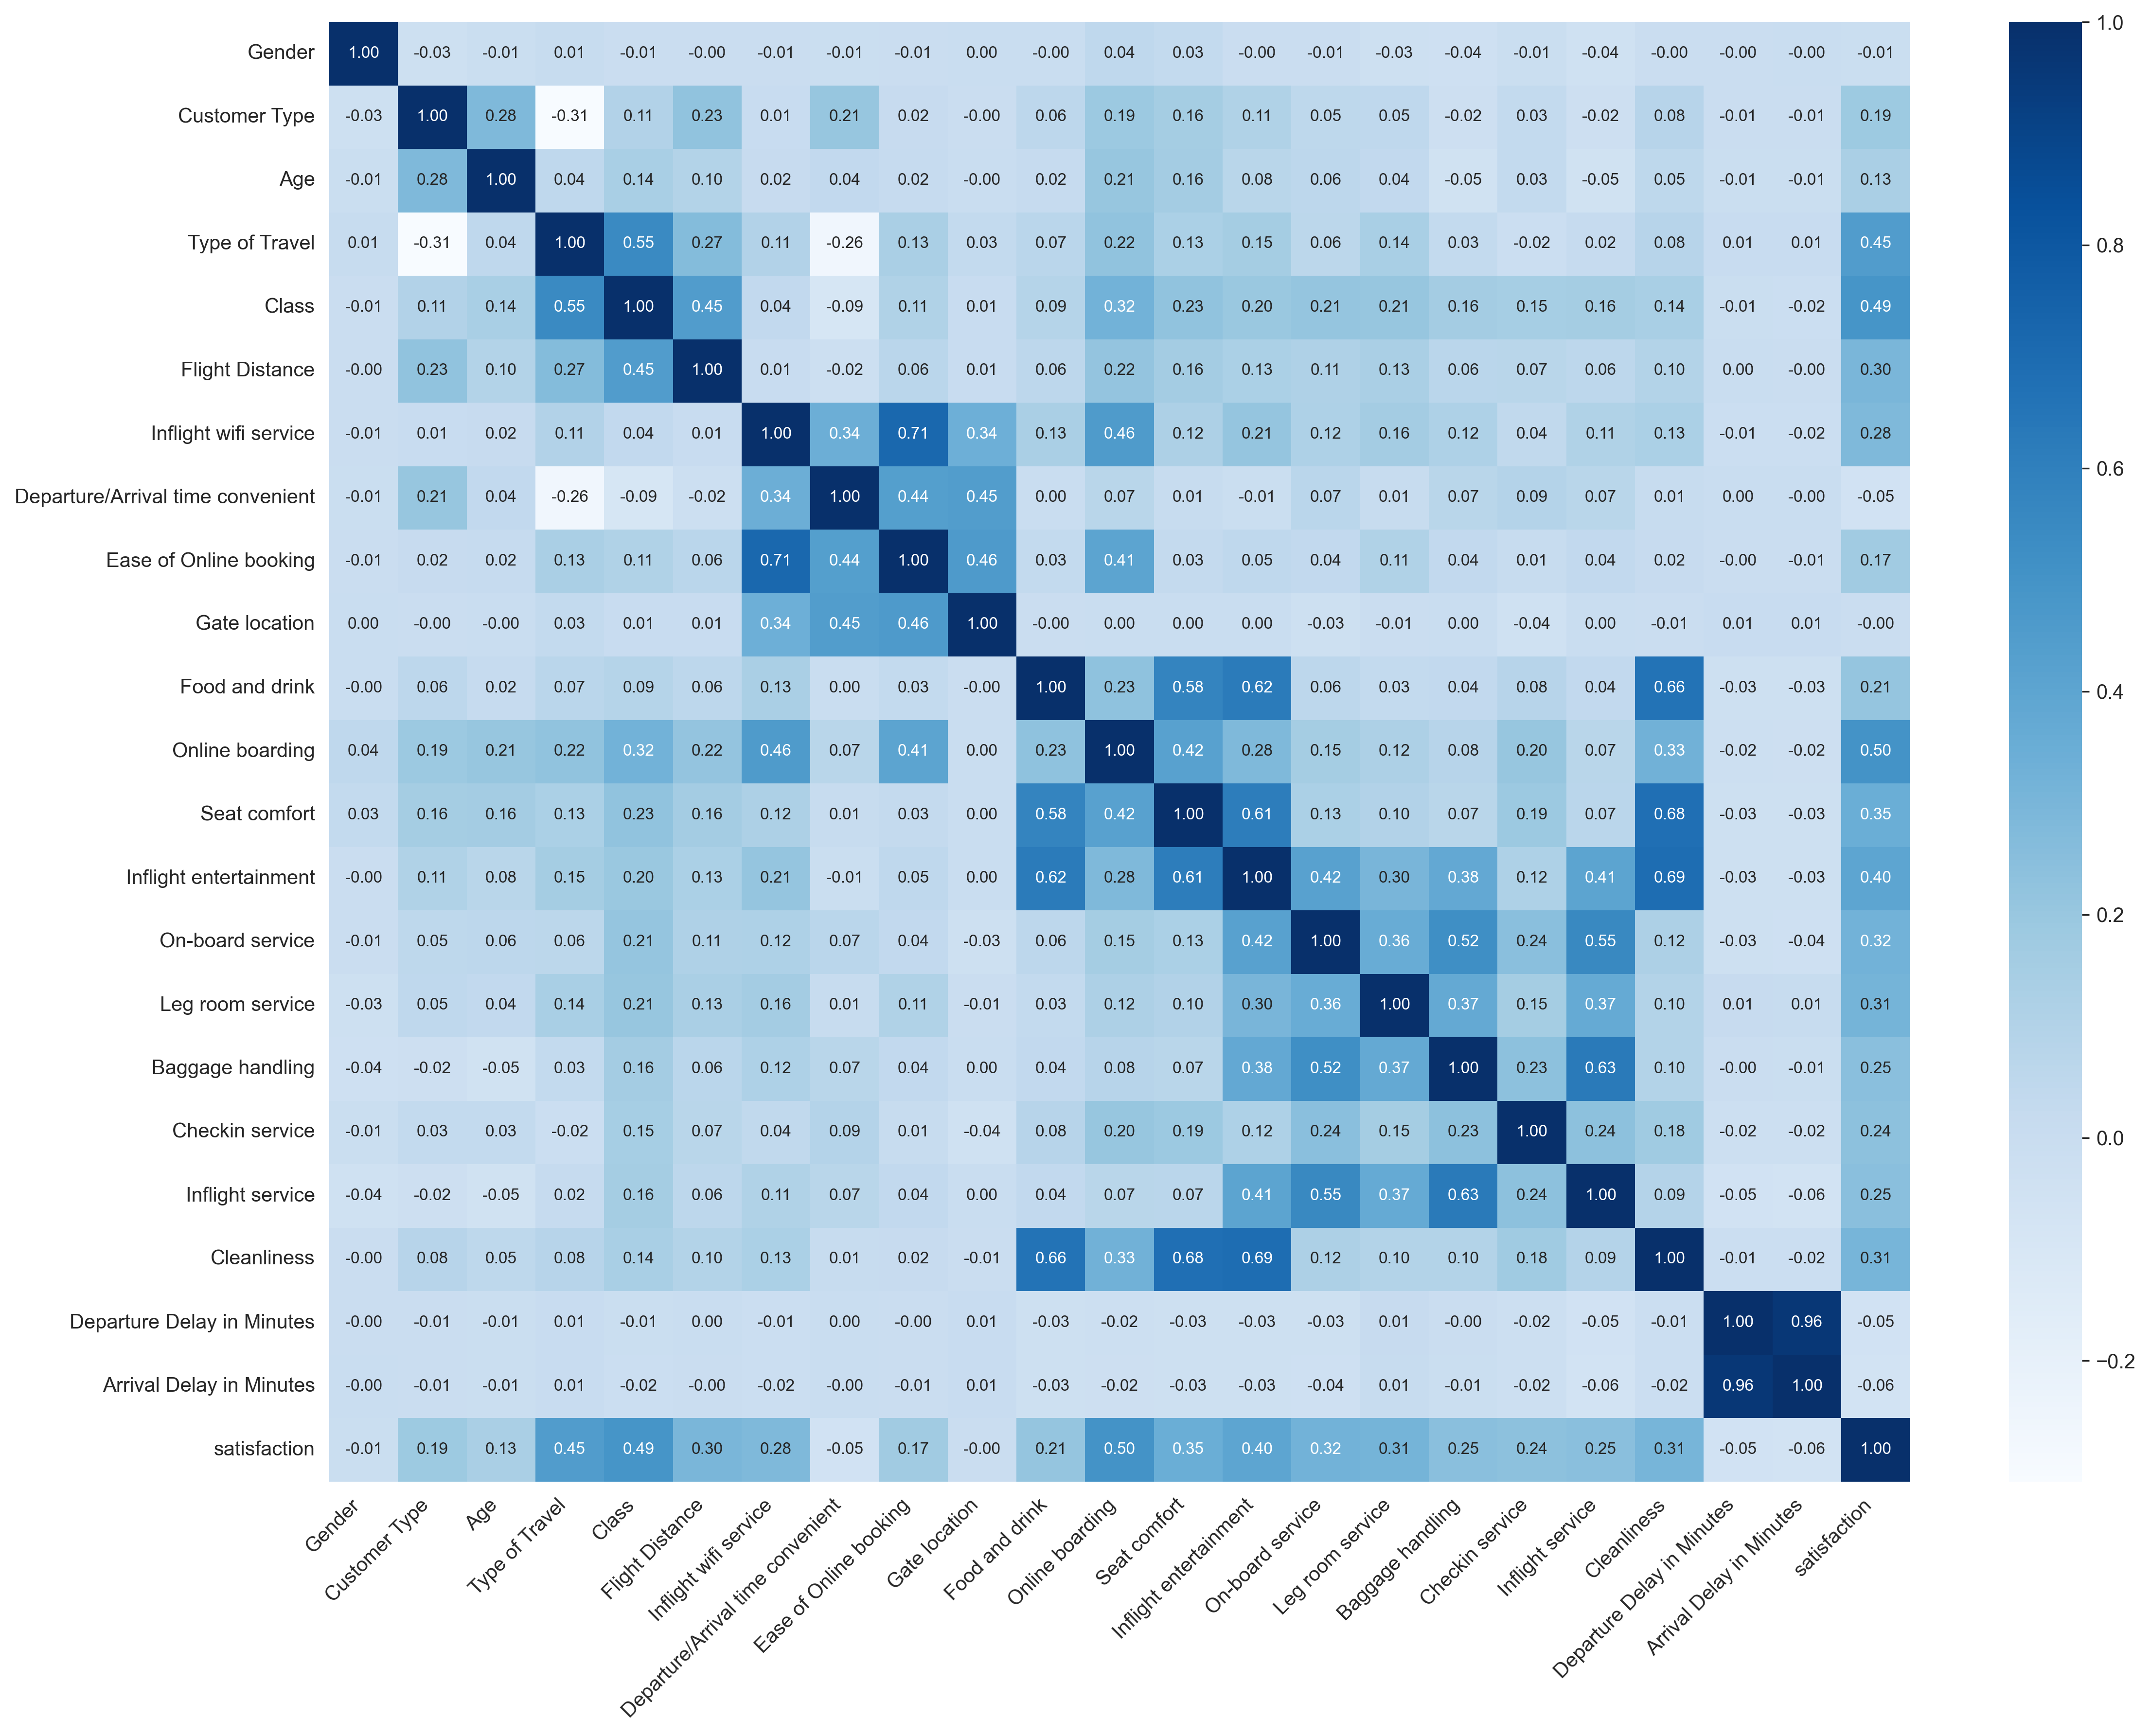

In [64]:
plt.figure(figsize=(16,12), dpi=300)  # Aumenta la dimensione e la risoluzione
heatmap = sns.heatmap(df.corr(), cmap='Blues', annot=True, fmt=".2f", annot_kws={"size": 8})
plt.xticks(rotation=45, ha='right', size=10)  # Ruota le etichette dell'asse x per leggibilità
plt.yticks(size=10)  # Aumenta la dimensione del font per le etichette dell'asse y
plt.tight_layout()  # Ajusta la disposizione
plt.show()

1. Inflight entertainment: Forte correlazione positiva con la soddisfazione.
2. Seat comfort (o Cleanliness): Scegliere una a causa della loro alta correlazione per evitare la multicollinearità.
3. Online boarding: Moderata correlazione positiva.
4. Leg room service: Moderata correlazione positiva.
5. On-board service: Moderata correlazione positiva.
6. Baggage handling: Moderata correlazione positiva.
7. Checkin service: Moderata correlazione positiva.
8. Class (o Type of Travel): entrambe hanno una moderata correlaazione con il target. Class dà un po' più di informazioni. Capiamo però la loro distribuzione (meglio quello con le classi meglio distribuite)Moderata correlazione positiva.

In [65]:
#Prima Screamtura DataFrame
# df = df[["Leg room service", "Inflight entertainment", "Online boarding", "Class", "Type of Travel", "On-board service", "Inflight service", "satisfaction"]]

#Seconda scrematura Dataframe
#df = df[["Leg room service", "Inflight entertainment", "Online boarding", "Checkin service", "Type of Travel", "On-board service", "Inflight service", "satisfaction"]]

In [66]:
y = df["satisfaction"]
X = df[["Leg room service", "Inflight entertainment", "Online boarding", "Checkin service", "Type of Travel", "On-board service", "Inflight service"]]

# Processing

In [67]:
train_test = StratifiedShuffleSplit(test_size = 0.2, n_splits = 1, random_state = 42)

for train_index, test_index in train_test.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

## Scelta del modello 

Useremo un ensemble method, di tipo omogeneo. Le scelte ricadono tra Random Forest (bagging) e XGBoost (boosting). Utilizzano entrambi come modello base il decision tree.
Il random forest può essere l'ideale per l'overfitting, in quanto crea decision tree indipendenti e li combina.
XGBoost potrebbe fare al caso nostro poiché massimizza la performance predittiva.

Li abbiamo provati entrambi.

Partiamo con XGBoost. 

## XGBoost

Nel pre-processing abbiamo fatto lo split tra Train e Test, con le features che abbiamo ritenuto migliori in base alla loro correlazione con il target. Tuttavia, mediante la funzione **'plot importance'** di XGBoost, sapremo quali features incidono maggiormente sul nostro modello. Con una funzione personalizzata faremo lo stesso con Random Forest. Quindi prendiamo in esame tutte le features presenti sui nostri dati e applichiamo uno standard scaler. La nostra Y non sarà oggetto dello scaling, vogliamo che resti tra 1 e 0.  Le variabili categoriche, anche se scalate, non raprresentano un problema.

Il modello base di XGBoost è un decision tree, il quale la scalatura/normalizzazione delle features non ha un impatto diretto o significativo -> Gli alberi decisionali si basano su split binari, il che significa che suddividono i dati in due gruppi utilizzando una singola feature in ogni passo. La magnitudine assoluta dei valori delle feature non influisce sul processo decisionale. Quindi, anche se le feature sono in scale diverse, l'albero può ancora dividerle correttamente in base al valore di soglia ottimale.

Tuttavia applichiamo lo scaling per le seguenti ragioni:
1. Importance delle features: avere tutte le feature nella stessa scala può rendere più facile confrontare l'importanza assegnata a ciascuna feature.
2. Convergenza più Rapida: Alcuni algoritmi come XGBoost per determinare i punti di split, possono convergere più rapidamente se i dati sono in una scala uniforme.

Sfrutteremo successivamente la stessa metodologia per il Random forests (con qualche cambiamento)

Useremo StratifiedShuffleSplit per una distribuzione uniforme

In [68]:
# Richiamo il df integro 
df

# X e y
X = df.drop('satisfaction',axis=1)
y = df['satisfaction']

# Train e Test
train_test = StratifiedShuffleSplit(test_size = 0.2, n_splits = 1, random_state = 42)

for train_index, test_index in train_test.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
#Scaling (solo per X) lasciamo y integra. 
scaler = StandardScaler()
scld_X_train = scaler.fit_transform(X_train)
scld_X_test = scaler.transform(X_test)

In [69]:
#Valutiamo la distribuzione tra Train e Test

#Per valutare distribuzione
np.bincount(y_train)/len(y_train), np.bincount(y_test)/len(y_test)

(array([0.56547809, 0.43452191]), array([0.56548102, 0.43451898]))

In [70]:
# Il risultato dello scaling è un Array. Trasformiamo X_Train e X_test in Dataframe -> per avere il nome delle colonne quando analizzare le features più importanti
scld_X_train = pd.DataFrame(scld_X_train, columns=X_train.columns)
scld_X_test = pd.DataFrame(scld_X_test, columns=X_test.columns)

#### Gridsearch

Passiamo alla GridSearch per identificare i migliori iper-parametri. Vengono indicati per comodità i migliori Iper-parametri stabiliti dalla grid search.

La gridsearch è stata impostata del seguente modo:

Modello base: xgb_classifier = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
* eval_metric in XGBoost -> utile per i modelli di classificazione binaria. 
* label encoder non necessario (già fatto)

Griglia di parametri
* **'max_depth': [3, 4, 5]** -> massima profondità di ciascun albero. Più profondo è l'albero, più complesse sono le relazioni che il modello può catturare. Tuttavia, alberi troppo profondi possono portare a overfitting. I valori scelti qui rappresentano alberi relativamente poco profondi, questo per  mantenere il modello semplice e prevenire l'overfitting.

* **'min_child_weight': [1, 5, 10]** -> il peso minimo necessario per continuare a dividere i nodi (alori più elevati possono portare a alberi più conservativi, poiché prevengono la creazione di nodi che corrispondono a poche istanze)

* **'gamma': [0.5, 1, 1.5, 2]** -> Funziona penalizzando il modello per l'aggiunta di ulteriori partizioni che non migliorano significativamente la performance del modello. Equilibrio tra Bias e Varianza: Un valore di gamma più alto rende l'algoritmo più conservativo: l'albero sarà meno propenso a crescere e quindi meno probabile che si adatti troppo ai dati di training. Al contrario, un valore più basso può permettere agli alberi di crescere più liberamente, potenzialmente migliorando la performance sui dati di training ma aumentando il rischio di overfitting.

* **'learning_rate': [0.01, 0.1, 0.2]** -> impatto degli alberi decisionali. Valore alto: ogni albero ha un forte impatto; si adatta rapidamente ai dati ma anche potenzialmente al rumore. Valore basso: ogni albero ha un impatto più moderato (approccio più cauto)

* **'n_estimators': [100, 200, 500]** -> Indica il numero di alberi (o round di boosting) da costruire

**Miglior parametri:** {'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 500}

**Best score:** 0.9627276985477909

Utilizzando eval_metric='logloss', stiamo dicendo a XGBoost di usare la log loss per guidare il processo di addestramento e per fare scelte su come aggiustare il modello ad ogni iterazione. 

In [71]:
# Creazione di un modello XGBoost
xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=300, random_state=42, eval_metric='logloss')

In [72]:
# Addestramento del modello
xgb_classifier.fit(scld_X_train, y_train)

# Predizione sui dati di test
predictions = xgb_classifier.predict(scld_X_test)

Effettuiamo adesso una Cross-Validation, utile per valutare la generalizzazione delle prestazioni del modello. Poiche stiamo trattando un problema di classificazione binaria la funzione `cross_val_score` ci restituirà un array di punteggi cje equivalgono all’accuratezza.

In [73]:
# Cross val score with cv = 25
scores = cross_val_score(xgb_classifier, scld_X_train, y_train, cv=25)
scores

array([0.9666908 , 0.95993242, 0.96644943, 0.96210476, 0.96572532,
       0.96234613, 0.96065653, 0.96500121, 0.96717355, 0.95969105,
       0.96572532, 0.96162201, 0.96427709, 0.96620806, 0.96596669,
       0.96427709, 0.96186338, 0.96162201, 0.9625875 , 0.96233704,
       0.96185418, 0.95992274, 0.96475133, 0.9604056 , 0.96064703])

In [74]:
# Media di scores
print(scores.mean())
print(scores.std())

0.9631935304650163
0.002384227427586503


Tutti i punteggi sono elevati e simili tra loro, ciò indica che il modello è stabile e si generalizza bene sui diversi subset dei dati. Non ci sono punteggi variabili, il che ci indica che non ci sono specifici subset di dati a cui il nostro modello è sensibile.

* La media conferma l'ottimo punteggio del modello.
* La deviazione standard ci fornisce una misura della variabilità o della consistenza della performance del modello attraverso i diversi fold della cross-validation. In questo caso la deviazione standard bassa ci indica che il modello è stabile e si comporta in modo simile su diversi sottoinsiemi dei dati.

Utilizziamo classification_report per avere a disposizione altre metriche oltre all'accuratezza. 

In [75]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97     14642
           1       0.97      0.94      0.96     11251

    accuracy                           0.96     25893
   macro avg       0.96      0.96      0.96     25893
weighted avg       0.96      0.96      0.96     25893



* Precision -> misura la percentuale di casi positivi identificati correttamente dal modello
* Recall (o True positive Rate) -> quanto è bravo il modello a rilevare i casi positivi tra tutti i casi effettivamente positivi presenti.
* f1-score -> combina Precision e Recall in un unico valore numerico.

Importiamo per completezza anche Specifity

* Specifity (o True Negative Rate) -> misura la capacità del modello di identificare correttamente tutti gli esempi negativi in un dataset.

In [76]:
# Sklearn non mette a disposizione nessuna funzione per Specifity. Facciamolo noi
def specificity_score(y_true, y_pred) -> float:
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    return specificity

print("Specifity score: ", specificity_score(y_test, predictions))

#Balanced accuracy
#print("balanced accuracy: ", balanced_accuracy_score(y_test, predictions))

Specifity score:  0.9806720393388881


Prima di procedere con ulteriori approfondimenti, limitiamoci ad ottenere le features più importanti. 

<Figure size 2000x2000 with 0 Axes>

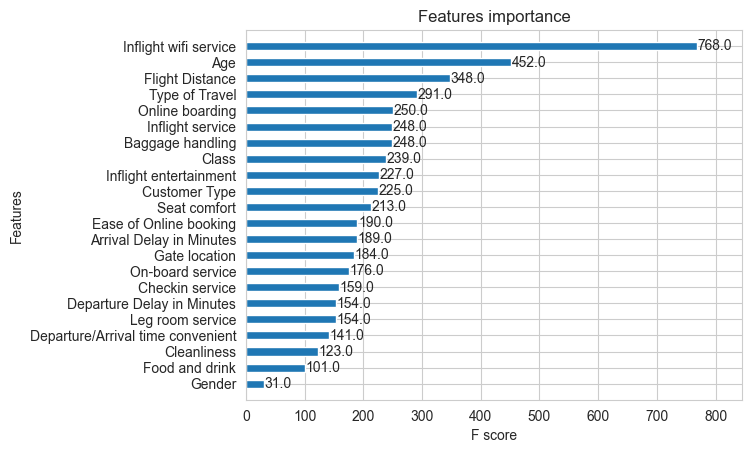

In [77]:
# Dimensioni Plot
plt.figure(figsize=(20, 20))

# Importanza delle Features
xgb.plot_importance(xgb_classifier, importance_type='weight', max_num_features=22, show_values=True, height=0.5)
plt.title('Features importance')
plt.show()

## Fit Modello con le features più importanti

In [78]:
# Richiamo il df integro 
df

# X -> sole 8 features più importanti per XGBoost
X = df[['Inflight wifi service', 'Age', 'Flight Distance', 'Type of Travel', 'Online boarding', 'Inflight service', 'Baggage handling', 'Class']]
y = df['satisfaction']

# Train e Test
train_test = StratifiedShuffleSplit(test_size = 0.2, n_splits = 1, random_state = 42)

for train_index, test_index in train_test.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
#Scaling (solo per X) lasciamo y integra. 
scaler = StandardScaler()
scld_X_train = scaler.fit_transform(X_train)
scld_X_test = scaler.transform(X_test)

# X_Train e X_test in Dataframe
scld_X_train = pd.DataFrame(scld_X_train, columns=X_train.columns)
scld_X_test = pd.DataFrame(scld_X_test, columns=X_test.columns)

In [79]:
# Addestramento del modello
xgb_classifier.fit(scld_X_train, y_train)

# Predizione sui dati di test
predictions = xgb_classifier.predict(scld_X_test)

Aggiungiamo il calcolo della Log Loss 

Poiché la Log Loss considera la probabilità predetta, penalizza sia le previsioni sicure che sono sbagliate, sia le previsioni incerte che sono corrette, ma non con alta confidenza. In altre parole, un modello viene penalizzato per essere troppo sicuro e sbagliato, così come per non essere abbastanza sicuro della corretta classificazione.

Più la Log Loss si avvicina a infinito, peggio è la performance del modello in termini di previsioni delle probabilità.
Un valore di Log Loss pari a 0 indica una perfezione teorica nel modello di classificazione, cioè la previsione della probabilità è sempre corretta.

In [80]:
# Assicurati di usare predict_proba per ottenere le probabilità della classe positiva
prob_predictions = xgb_classifier.predict_proba(scld_X_test)[:, 1]

# Calcolo della log loss
loss = log_loss(y_test, prob_predictions)
print(f'Log Loss: {loss}')

Log Loss: 0.1596178224104039


Rifacciamo gli stessi check fatti precedentemente. 

In [81]:
# Cross val score with cv = 25
scores = cross_val_score(xgb_classifier, scld_X_train, y_train, cv=25)
print(scores)

[0.93531258 0.93314024 0.94038137 0.9350712  0.93024378 0.92903693
 0.93338161 0.93700217 0.93700217 0.93555395 0.93917451 0.93145064
 0.93531258 0.93820903 0.93362298 0.94038137 0.93289887 0.93700217
 0.93169201 0.9348141  0.93602125 0.93602125 0.93336552 0.9348141
 0.93602125]


In [82]:
# Media di scores
print(scores.mean())
print(scores.std())

0.9350771041029222
0.0028142939713582094


In [83]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.93      0.96      0.94     14642
           1       0.94      0.91      0.92     11251

    accuracy                           0.93     25893
   macro avg       0.94      0.93      0.93     25893
weighted avg       0.93      0.93      0.93     25893



In [84]:
print("Specifity score: ", specificity_score(y_test, predictions))

Specifity score:  0.9566316077038656


Un buon modello deve essere in grado di identificare correttamente sia i positivi (P) che i negativi (N). Per farlo useremo una confusion matrix

- TP → True positive → quando il modello classifica correttamente un esempio come positivo (classe positiva). il modello ha fatto una previsione corretta.
- FP → False positive → quando il modello classifica erroneamente un esempio come positivo quando in realtà è negativo (classe negativa). Il modello non avrebbe dovuto farlo.
- TN → True Negative → quando il modello classifica correttamente un esempio come negativo (classe positiva). il modello ha fatto una previsione corretta per la classe negativa.
- FN → False Negative → quando il modello classifica erroneamente un esempio come negativo quando in realtà è positivo (classe negativa). Il modello non avrebbe dovuto farlo.

True Positive: 0.3933495539334955
False Positive: 0.024524002626192407
True Negative: 0.5409570154095702
False Negative: 0.041169428030741896


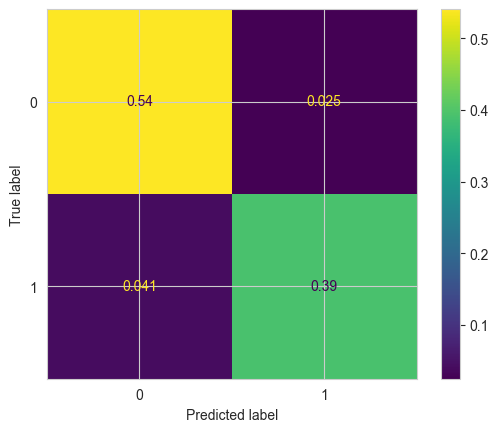

In [85]:
# Calcola la matrice di confusione
cm = confusion_matrix(y_test, predictions, normalize='all')

# Usa ravel per estrarre TP, FP, TN, FN
tn, fp, fn, tp = cm.ravel()

print(f"True Positive: {tp}")
print(f"False Positive: {fp}")
print(f"True Negative: {tn}")
print(f"False Negative: {fn}")

# Visualizza la matrice di confusione
ConfusionMatrixDisplay(cm).plot()

Faremo adesso uso della Curva ROC (Receiver Operating Characteristic) e di un grafico Precisione-Richiamo che rappresenti ... ""

### Curva ROC

La Curva ROC è uno strumento utilizzato per valutare la performance di un modello di classificazione binaria. La curva ROC è un grafico che mostra il trade-off (compromesso) tra il tasso di veri positivi (True Positive Rate, TPR -> sensibility) e il tasso di falsi positivi (False Positive Rate, FPR -> specificity) e i vari threshold di classificazione. In pratica, ogni punto sulla curva ROC rappresenta una coppia sensibilità/specificità corrispondente ad una particolare soglia decisionale. 

 Useremo la funzione 'roc_curve' che ci dà tre array 
1. FPR -> False Positive Rate per ogni possibile threshold
2. TPR -> True positive rate per ogni possibile threshold
3. Threshold -> Un array di threshold a cui corrispondono FPR e TPR specifici.

* Linea diagonale tratteggiata - AUC: Rappresenta un classificatore casuale (si comporta come se stesse semplicemente indovinando). Un buon modello avrà una curva ROC che si trova sopra la diagonale verso l'angolo superiore sinistro, indicando che ha una performance migliore rispetto al caso casuale.
Area sotto la curva (AUC): È un singolo valore che riassume la performance del modello. Varia da 0 a 1, dove 1 indica una performance perfetta e 0.5 indica un modello non migliore di un lancio di moneta casuale. 


### Curva Precision - Recall 

La curva Precisione-Richiamo traccia la precisione (sull'asse Y) contro il richiamo (sull'asse X) per diversi valori di threshold. Questi threshold variano da 0 a 1, alterando il bilanciamento tra precisione e richiamo. Un modello ideale avrebbe una curva che arriva nell'angolo in alto a destra, indicando sia alta precisione sia alto richiamo.

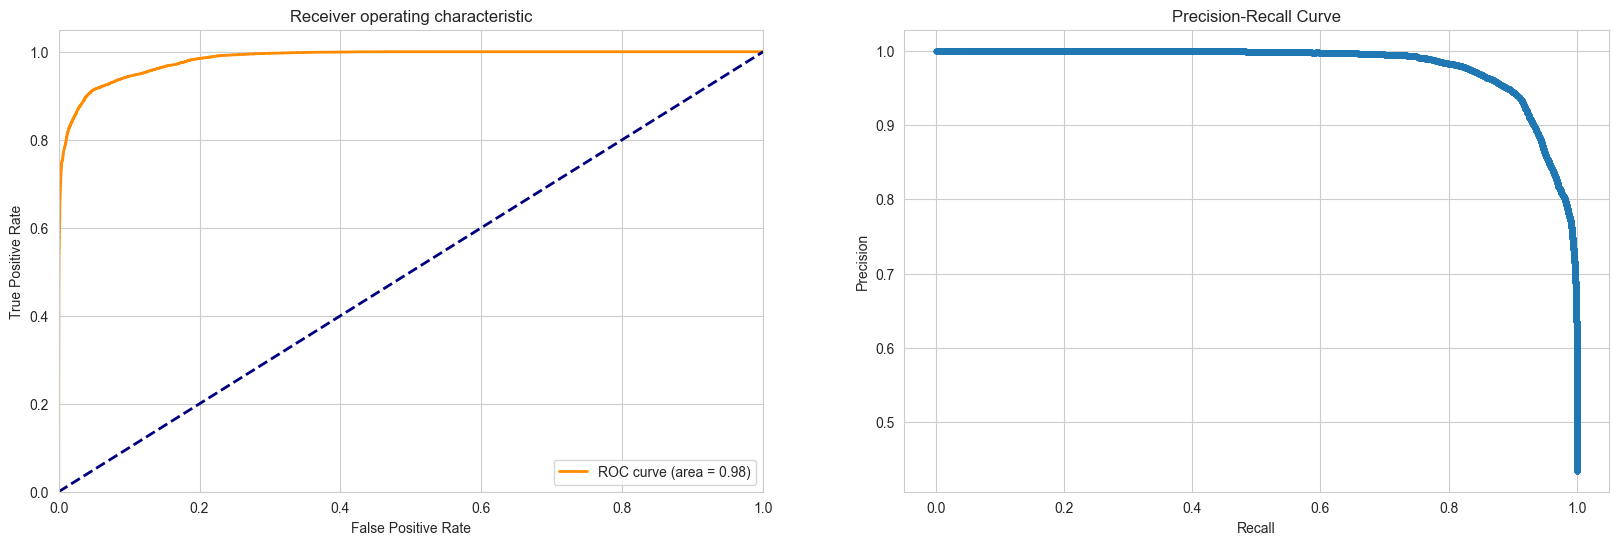

In [86]:
# Dimensioni Plot
plt.figure(figsize=(20, 6))

# Curva ROC e AUC - plot 1
plt.subplot(1, 2, 1)  
fpr, tpr, thresholds = roc_curve(y_test, xgb_classifier.predict_proba(scld_X_test)[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

# Calcolare precisione e richiamo - plot 2
plt.subplot(1, 2, 2)  
precision, recall, thresholds = precision_recall_curve(y_test, xgb_classifier.predict_proba(scld_X_test)[:, 1])
plt.plot(recall, precision, marker='.')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')

# Visualizzare i grafici
plt.show()

Le prestazione di questo nuovo modello XGBoost non si discostano di tanto dal precedente (con tutte le features). Sia con la confusion matrix sia con la crox validation possiamo constatare la solidità del modello. 

## Random Forests

Seguaimo la stessa metodologia fatta con XGBoost

In [87]:
# Richiamo il df integro 
df

# X e y
X = df.drop('satisfaction',axis=1)
y = df['satisfaction']

# Train e Test
train_test = StratifiedShuffleSplit(test_size = 0.2, n_splits = 1, random_state = 42)

for train_index, test_index in train_test.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
#Scaling (solo per X) lasciamo y integra. 
scaler = StandardScaler()
scld_X_train = scaler.fit_transform(X_train)
scld_X_test = scaler.transform(X_test)

scld_X_train = pd.DataFrame(scld_X_train, columns=X_train.columns)
scld_X_test = pd.DataFrame(scld_X_test, columns=X_test.columns)

Passiamo alla GridSearch per identificare i migliori iper-parametri. Vengono indicati per comodità i migliori Iper-parametri stabiliti dalla grid search.

La gridsearch è stata impostata del seguente modo:

Modello base: randomForests_classifier = RandomForestClassifier(random_state=42)

Griglia di parametri:

* **'max_depth: [3, 4, 5]** -> profondità massima degli alberi. Stessi valori di XGBoost. Valori piccoli per mantenere il modello semplice e prevenire l''overfitting 

* **'max_leaf_nodes'**: [16, 32, None] -> limitare creazione dei nodi. 16 e 32 per tenerlo sotto controllo. None per non dargli nessun limite

* **'min_samples_split'**: [2, 4, 6] -> numero minimo di campioni per dividere un nodo. 

* **'n_estimators'**: [100, 200, 500]


* Migliori parametri: {'max_depth': 5, 'max_leaf_nodes': None, 'min_samples_split': 6, 'n_estimators': 500}
* Miglior punteggio: 0.9240942570980941

In [88]:
# Creazione di un modello random Forests. Aggiungiamo l'iperparametro oob_score per calcolarci successivamente il out-of-bag score
randomForests_classifier = RandomForestClassifier(max_depth=5, max_leaf_nodes=None, min_samples_split=6, n_estimators=500, random_state=42, oob_score=True)

# Addestramento del modello
randomForests_classifier.fit(scld_X_train, y_train)

# Predizione sui dati di test
predictions = randomForests_classifier.predict(scld_X_test)

In [89]:
# Estrai l'importanza delle feature (utile per plottare)
feature_importances = randomForests_classifier.feature_importances_
feature_importances

array([0.00064934, 0.02608491, 0.00727692, 0.13331543, 0.14935291,
       0.01887036, 0.14161944, 0.00664965, 0.02867834, 0.0035196 ,
       0.00443884, 0.22298645, 0.05124597, 0.07725405, 0.02676938,
       0.04315964, 0.01423447, 0.00820435, 0.0126296 , 0.02159981,
       0.00035994, 0.00110058])

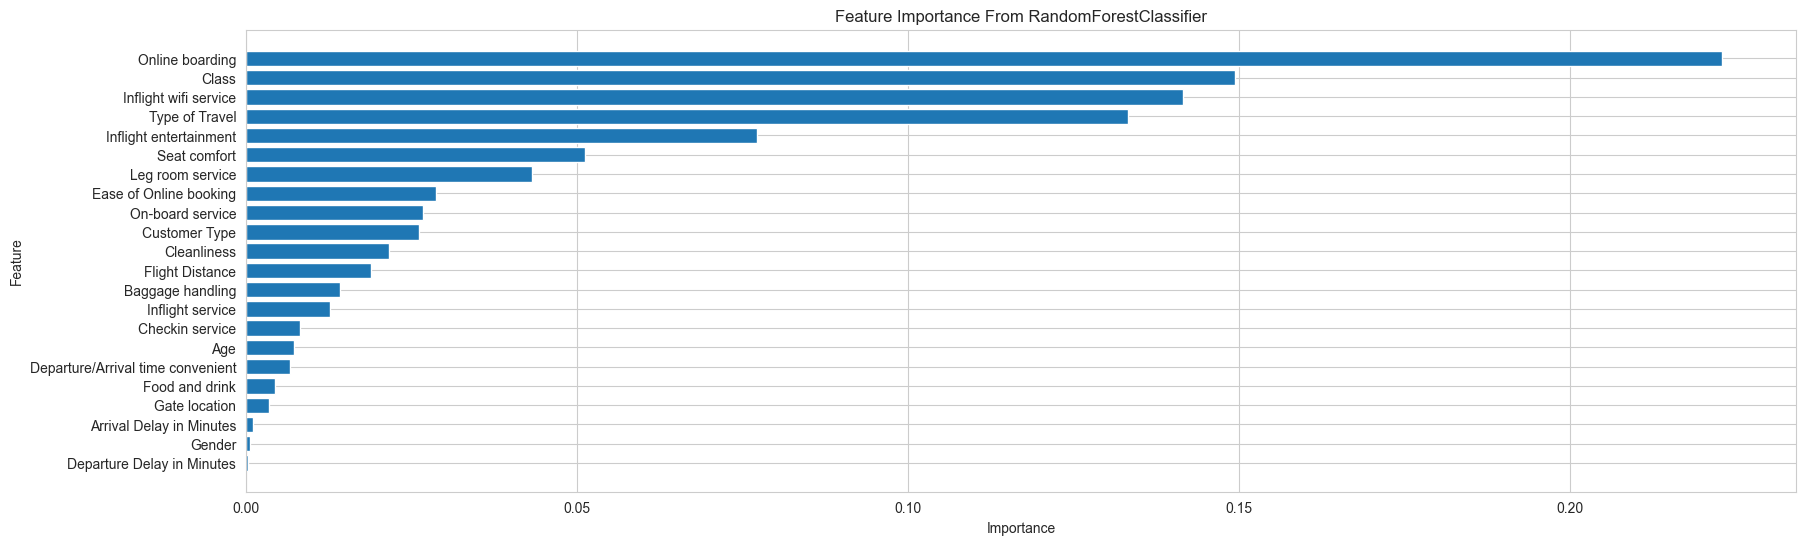

In [90]:
# Dimensioni Plot
plt.figure(figsize=(20, 6))

# Ordinare le features in base all'importanza (le più importanti vengono per prime)
sorted_idx = np.argsort(feature_importances)[::-1]

# Creare le etichette per le feature
feature_labels = X_train.columns[sorted_idx] 

# Visualizza l'importanza delle feature in un grafico a barre
plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), feature_labels)
plt.gca().invert_yaxis()  # Inverti l'asse Y per mostrare la feature più importante in alto
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance From RandomForestClassifier')
plt.show()

Come possiamo constatare, le features più rilevanti cambiano in base al modello

XGBoost ha ritenuto più importanti le seguenti features:
Inflight wifi service, Age, Flight Distance, Type of Travel, Customer Type, Online boarding, Inflight service, Class

Random Forests invece: 
Online boarding, Class, Inflight wifi service, Type of travel, Inflight entertainment, seat confort, Leg room service, Ease of Online booking

### Features in comune:
Entrambi i modelli, XGBoost e Random Forests, hanno identificato alcune features come cruciali per la predizione. Queste includono:
* "Inflight wifi service": Sia XGBoost che Random Forests hanno trovato che il servizio wifi a bordo è una caratteristica significativa.
* "Type of Travel": Entrambi i modelli hanno rilevato che il tipo di viaggio (ad esempio, viaggio d'affari o personale) è importante.
* "Class": La classe di viaggio, come la classe economica o business, è stata identificata da entrambi i modelli come una feature rilevante.
* "Online boarding": Il processo di imbarco online è una feature comune selezionata da entrambi i modelli.

### Features diverse:
Mentre ci sono anche differenze significative nelle features ritenute importanti dai due modelli:
* XGBoost ha dato importanza a "Age" e "Flight Distance", che non sono state evidenziate dal modello Random Forest.
* "Customer Type" e "Inflight service" sono state considerate importanti in XGBoost, ma non in Random Forest.
* Random Forest ha trovato "Inflight entertainment", "Seat comfort", "Leg room service" e "Ease of Online booking" come più rilevanti, che non sono state altrettanto enfatizzate in XGBoost.

## Boosting 

* Interazione tra Feature: Poiché gli alberi vengono costruiti in modo sequenziale, XGBoost può catturare interazioni complesse tra feature. Di conseguenza, feature che sono particolarmente efficaci nel ridurre l'errore in interazioni specifiche possono essere valutate come più importanti.

* Ponderazione degli Errori: XGBoost dà più peso agli esempi che sono stati difficili da classificare nei round precedenti, il che potrebbe portare alcune feature ad apparire più rilevanti se aiutano a classificare questi casi difficili.

## Bagging

* Riduzione della Varianza: Poiché ogni albero in un Random Forest è costruito su un campione casuale del dataset, questo metodo è efficace nella riduzione della varianza. Le feature che mostrano una forte capacità di dividere i dati in modi consistenti in diversi campioni casuali possono apparire come più importanti.

* Generalizzazione: Random Forests tende a essere meno sensibile alle specifiche interazioni tra feature e più focalizzato su identificare feature che sono generalmente informative.

### Considerazioni 

XGBoost è molto focalizzato sulla correzione degli errori e può catturare dettagli complessi (ma rischia di overfitting), mentre Random Forests è più robusto contro l'overfitting ma potrebbe non catturare alcune sottili interazioni tra le feature.

## Confronto XGBoost e Random Forests 

In [91]:
y = df['satisfaction']

#Distringuiamo la X più rilevante per XGBoost e per Random Forests  

# X -> solo le 8 features più importanti per XGBoost
X = df[['Inflight wifi service', 'Age', 'Flight Distance', 'Type of Travel', 'Online boarding', 'Inflight service', 'Baggage handling', 'Class']]

# Train e Test
train_test = StratifiedShuffleSplit(test_size = 0.2, n_splits = 1, random_state = 42)

for train_index, test_index in train_test.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
#Scaling (solo per X) lasciamo y integra. 
scaler = StandardScaler()
scld_X_train_xgb = scaler.fit_transform(X_train)
scld_X_test_xgb = scaler.transform(X_test)

# X_Train e X_test in Dataframe
scld_X_train_xgb = pd.DataFrame(scld_X_train_xgb, columns=X_train.columns)
scld_X_test_xgb = pd.DataFrame(scld_X_test_xgb, columns=X_test.columns)


# X -> solo le 8 features più importanti per Random Forests
X = df[['Online boarding', 'Class', 'Inflight wifi service', 'Type of Travel', 'Inflight entertainment', 'Seat comfort', 'Leg room service', 'Ease of Online booking']]

# Train e Test
train_test = StratifiedShuffleSplit(test_size = 0.2, n_splits = 1, random_state = 42)

for train_index, test_index in train_test.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
#Scaling (solo per X) lasciamo y integra. 
scaler = StandardScaler()
scld_X_train_rnf = scaler.fit_transform(X_train)
scld_X_test_rnf = scaler.transform(X_test)

# X_Train e X_test in Dataframe
scld_X_train_rnf = pd.DataFrame(scld_X_train_rnf, columns=X_train.columns)
scld_X_test_rnf = pd.DataFrame(scld_X_test_rnf, columns=X_test.columns)

In [92]:
# Fit e predizione random Forests
randomForests_classifier.fit(scld_X_train_rnf, y_train)
predictions_rnf = randomForests_classifier.predict(scld_X_test_rnf)

# Fit e predizione XGBoost
xgb_classifier.fit(scld_X_train_xgb, y_train)
predictions_xgb = xgb_classifier.predict(scld_X_test_xgb)

In [93]:
# Cross val XGB
print('Cross-Validation XGBoost:')
scores_xgb = cross_val_score(xgb_classifier, scld_X_train_xgb, y_train, cv=25)
print(scores_xgb)

print('____________')

# Cross val Random Forests
print('Cross-Validation Random Forests: ')
scores_rnf = cross_val_score(randomForests_classifier, scld_X_train_rnf, y_train, cv=25)
print(scores_rnf)

Cross-Validation XGBoost:


[0.93531258 0.93314024 0.94038137 0.9350712  0.93024378 0.92903693
 0.93338161 0.93700217 0.93700217 0.93555395 0.93917451 0.93145064
 0.93531258 0.93820903 0.93362298 0.94038137 0.93289887 0.93700217
 0.93169201 0.9348141  0.93602125 0.93602125 0.93336552 0.9348141
 0.93602125]
____________
Cross-Validation Random Forests: 
[0.91841661 0.90658943 0.9160029  0.91165822 0.91334782 0.9085204
 0.91503741 0.9234854  0.91720975 0.91576153 0.91383056 0.91165822
 0.91407193 0.91576153 0.91189959 0.91865798 0.90924451 0.91479604
 0.90731354 0.91477547 0.91260261 0.91380975 0.90560116 0.91960406
 0.91260261]


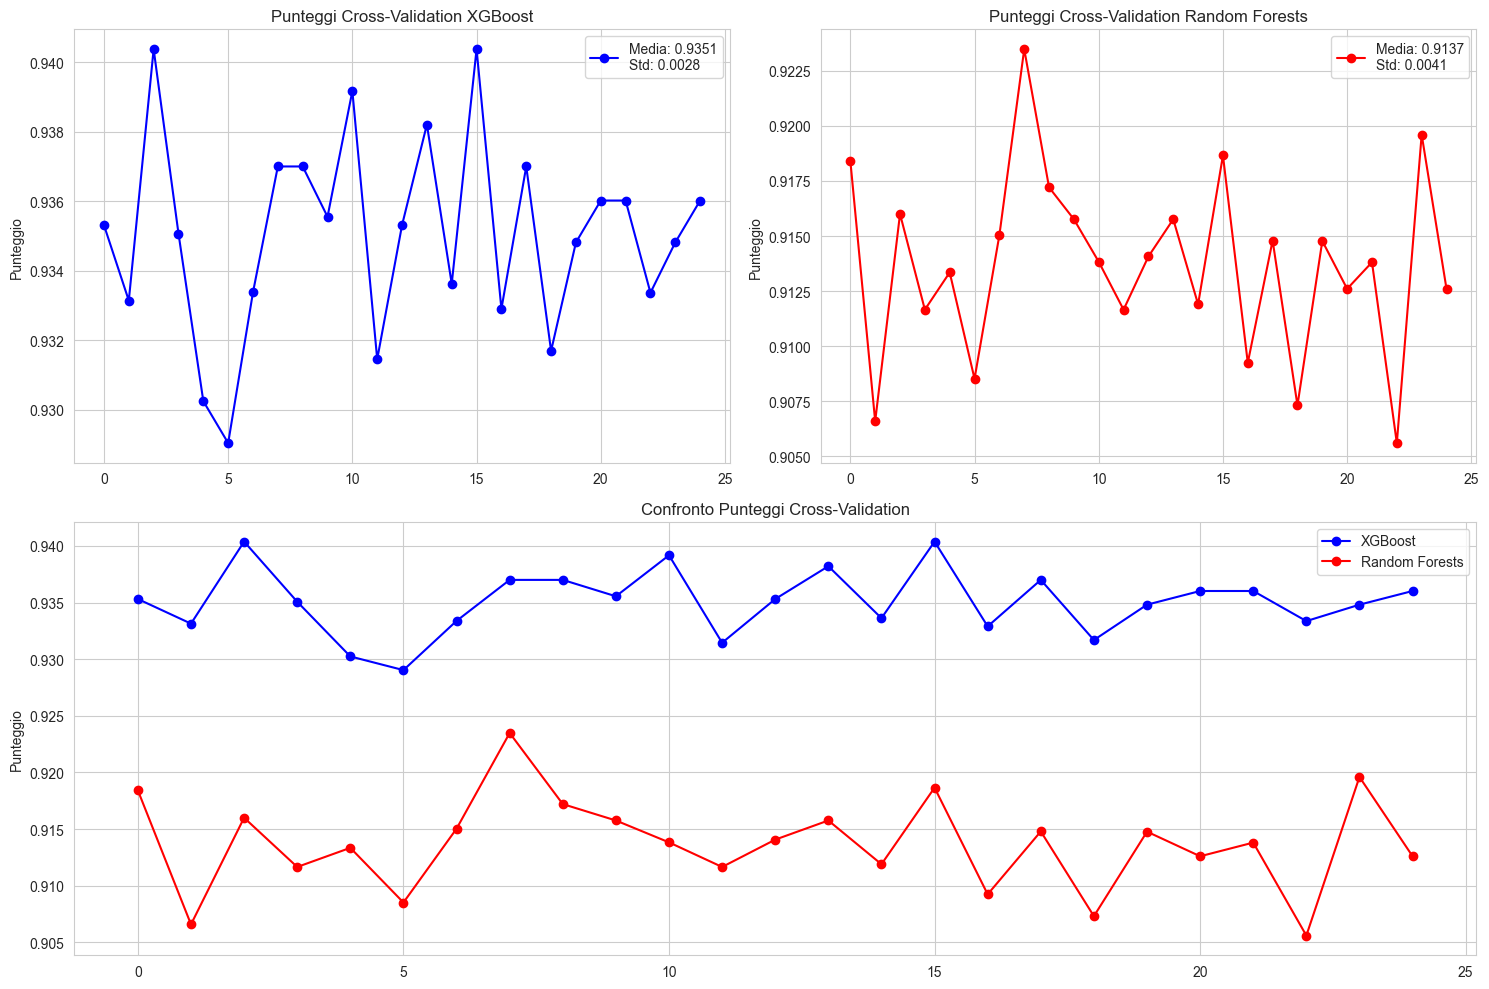

In [94]:
# Variabili per sintetizzare
mean_xgb = scores_xgb.mean()
std_xgb = scores_xgb.std()

mean_rnf = scores_rnf.mean()
std_rnf = scores_rnf.std()

# Dimensioni grafici
plt.figure(figsize=(15, 10))

# Primo Plot -> XGBoost
plt.subplot(2, 2, 1)  # Prima riga, prima colonna
plt.plot(scores_xgb, marker='o', linestyle='-', label=f'Media: {mean_xgb:.4f}\nStd: {std_xgb:.4f}', color='blue')
plt.title('Punteggi Cross-Validation XGBoost')
plt.ylabel('Punteggio')
plt.grid(True)
plt.legend()

# Secondo plot -> Random Forests
plt.subplot(2, 2, 2)  
plt.plot(scores_rnf, marker='o', linestyle='-', label=f'Media: {mean_rnf:.4f}\nStd: {std_rnf:.4f}', color='red')
plt.title('Punteggi Cross-Validation Random Forests')
plt.ylabel('Punteggio')
plt.grid(True)
plt.legend()

# Terzo plot -> confronto
plt.subplot(2, 1, 2)
plt.plot(scores_xgb, marker='o', linestyle='-', label='XGBoost', color='blue')
plt.plot(scores_rnf, marker='o', linestyle='-', label='Random Forests', color='red')
plt.title('Confronto Punteggi Cross-Validation')
plt.ylabel('Punteggio')
plt.grid(True)
plt.legend()

# Visualizzazione plot
plt.tight_layout() # per regolare automaticamente regola le dimensioni e le posizioni dei subplot
plt.show()

Entrambi i modelli mostrano performance relativamente stabili e consistenti attraverso le diverse iterazioni della cross-validation. Random Forests tende a superare leggermente XGBoost in termini di punteggio medio, ma la differenza non è significativa.

Entrambi i grafici mostrano alcuni picchi e valli, che suggeriscono la presenza di particolari split nei dati di training che sono stati o particolarmente favorevoli o sfavorevoli per il modello.

In [95]:
print('XGBoost:')
print(classification_report(y_test, predictions_xgb))

print('____________')

print('Random Forests:')
print(classification_report(y_test, predictions_rnf))

XGBoost:
              precision    recall  f1-score   support

           0       0.93      0.96      0.94     14642
           1       0.94      0.91      0.92     11251

    accuracy                           0.93     25893
   macro avg       0.94      0.93      0.93     25893
weighted avg       0.93      0.93      0.93     25893

____________
Random Forests:
              precision    recall  f1-score   support

           0       0.93      0.92      0.92     14642
           1       0.89      0.90      0.90     11251

    accuracy                           0.91     25893
   macro avg       0.91      0.91      0.91     25893
weighted avg       0.91      0.91      0.91     25893



True Positive: 0.3933495539334955
False Positive: 0.024524002626192407
True Negative: 0.5409570154095702
False Negative: 0.041169428030741896
True Positive: 0.3930405901208821
False Positive: 0.047116981423550766
True Negative: 0.5183640366122118
False Negative: 0.04147839184335535


<Figure size 2000x600 with 0 Axes>

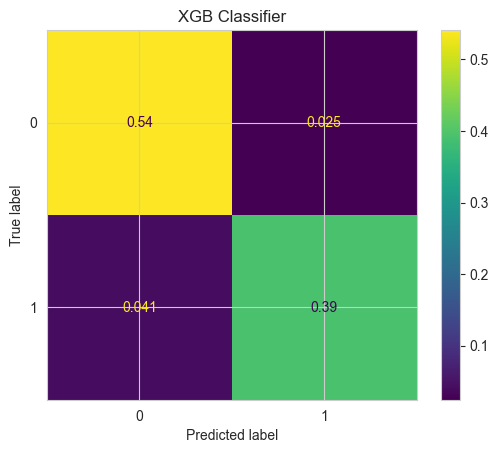

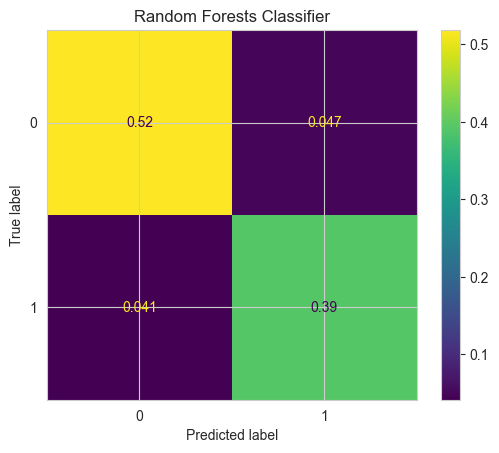

In [96]:
# Dimensioni Plot
plt.figure(figsize=(20, 6))

# matrice di confusione XGB
#plt.subplot(2, 1, 1)  
cm = confusion_matrix(y_test, predictions_xgb, normalize='all')
tn, fp, fn, tp = cm.ravel()
print(f"True Positive: {tp}")
print(f"False Positive: {fp}")
print(f"True Negative: {tn}")
print(f"False Negative: {fn}")
ConfusionMatrixDisplay(cm).plot()
plt.title("XGB Classifier")


# matrice di confusione Random Forest
#plt.subplot(2, 1, 2)  
cm = confusion_matrix(y_test, predictions_rnf, normalize='all')
tn, fp, fn, tp = cm.ravel()
print(f"True Positive: {tp}")
print(f"False Positive: {fp}")
print(f"True Negative: {tn}")
print(f"False Negative: {fn}")
ConfusionMatrixDisplay(cm).plot()
plt.title("Random Forests Classifier") 


plt.show()

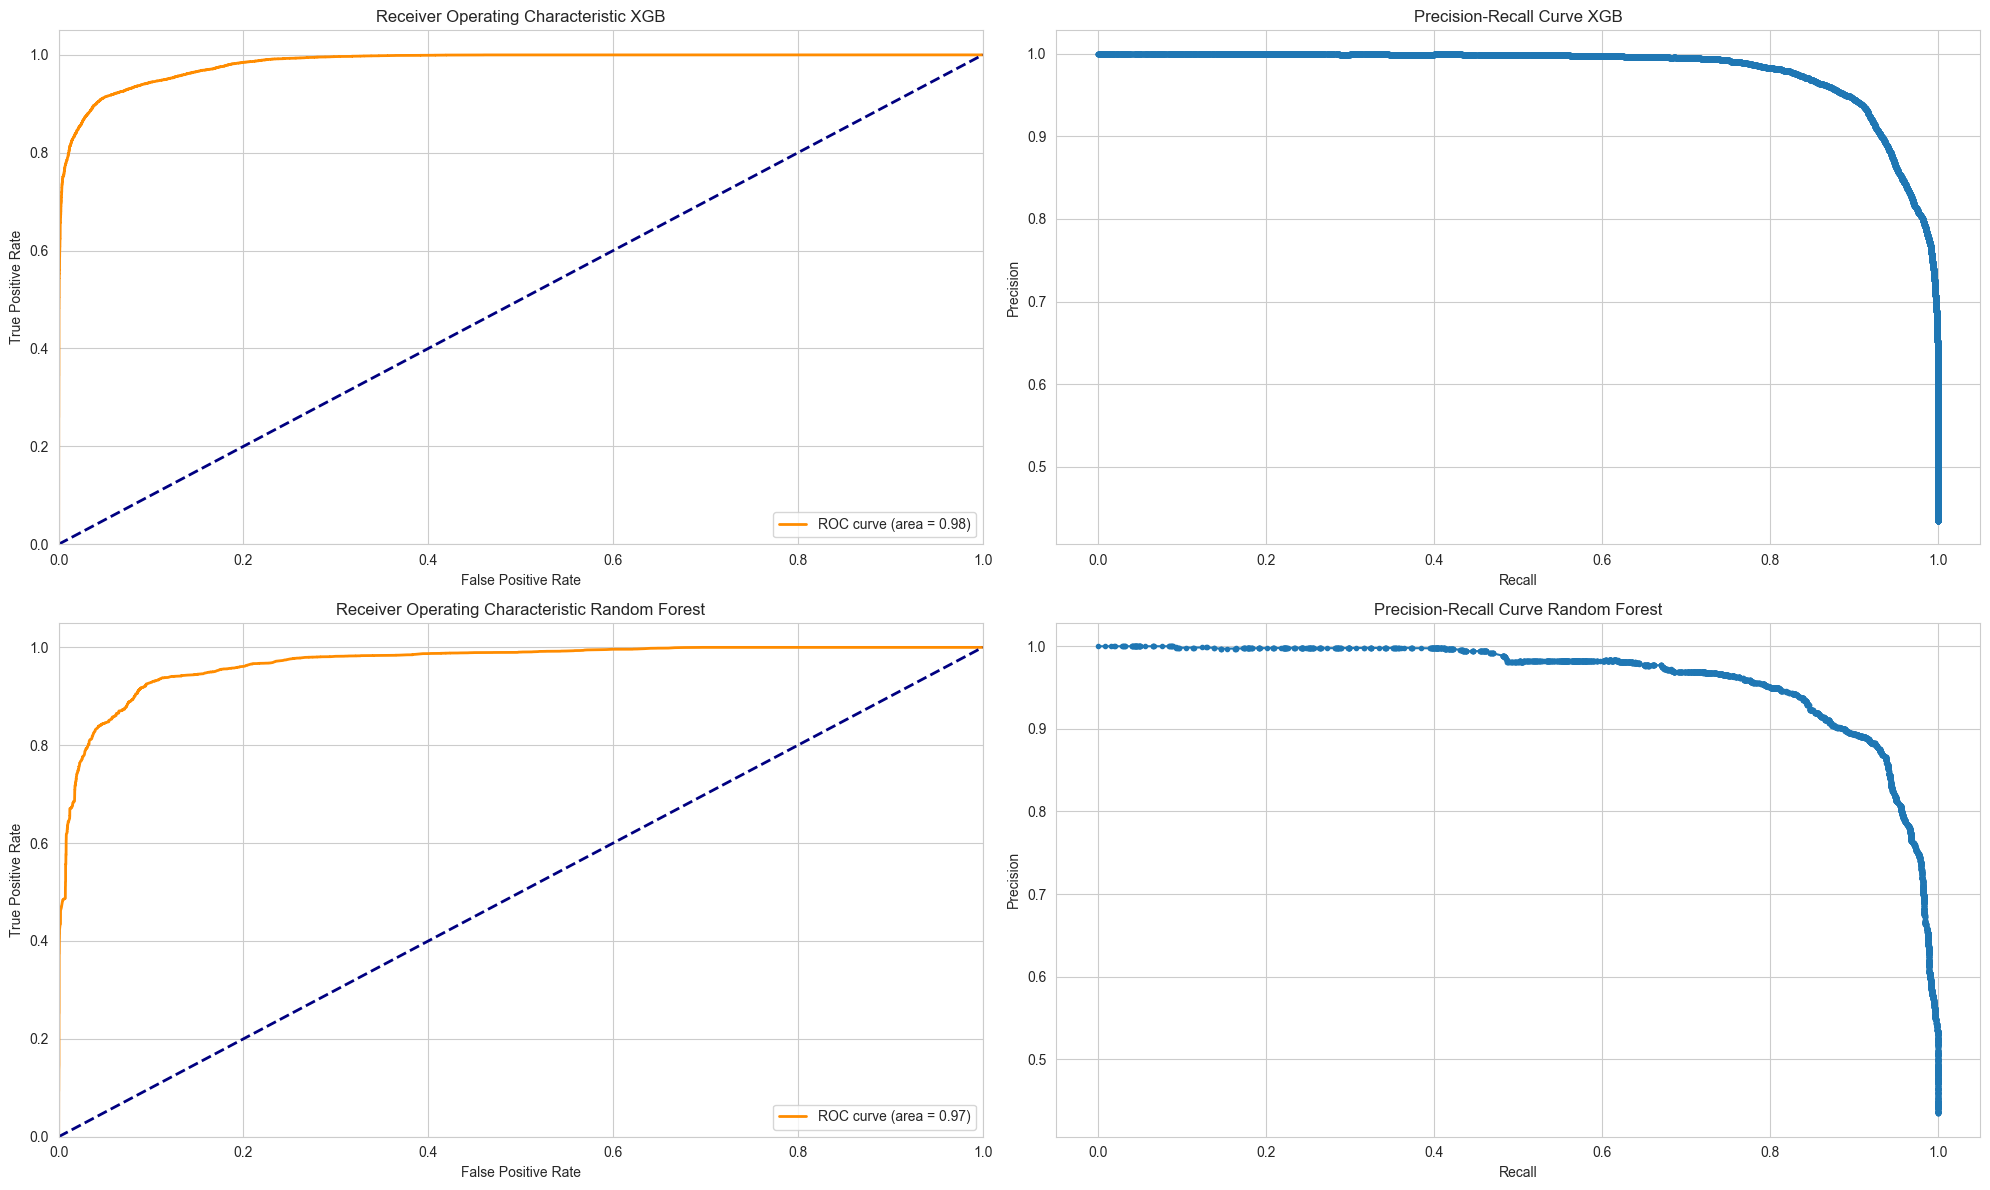

In [97]:
# Dimensioni Plot
plt.figure(figsize=(20, 12))  # Aumento dell'altezza per ospitare due righe di subplot

# XGB -> Curva ROC e AUC - plot 1
plt.subplot(2, 2, 1)  # Prima riga, prima colonna
fpr, tpr, thresholds = roc_curve(y_test, xgb_classifier.predict_proba(scld_X_test_xgb)[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic XGB')
plt.legend(loc="lower right")

# XGB -> Grafico di Precisione e Richiamo - plot 2
plt.subplot(2, 2, 2)  # Prima riga, seconda colonna
precision, recall, thresholds = precision_recall_curve(y_test, xgb_classifier.predict_proba(scld_X_test_xgb)[:, 1])
plt.plot(recall, precision, marker='.')
plt.title('Precision-Recall Curve XGB')
plt.xlabel('Recall')
plt.ylabel('Precision')

# Random Forest -> Curva ROC e AUC - plot 3
plt.subplot(2, 2, 3)  # Seconda riga, prima colonna
fpr, tpr, thresholds = roc_curve(y_test, randomForests_classifier.predict_proba(scld_X_test_rnf)[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Random Forest')
plt.legend(loc="lower right")

# Random Forest -> Grafico di Precisione e Richiamo - plot 4
plt.subplot(2, 2, 4)  # Seconda riga, seconda colonna
precision, recall, thresholds = precision_recall_curve(y_test, randomForests_classifier.predict_proba(scld_X_test_rnf)[:, 1])
plt.plot(recall, precision, marker='.')
plt.title('Precision-Recall Curve Random Forest')
plt.xlabel('Recall')
plt.ylabel('Precision')

# Visualizzazione dei grafici
plt.tight_layout()
plt.show()

Calcoliamo adesso l'OOB score (out-of-bag). Quando si utilizza il campionamento con rimpiazzo nel bagging (random forests), alcuni campioni del dataset originale possono essere ripetuti in un sottoinsieme, mentre altri possono non essere selezionati affatto. I campioni che non vengono selezionati sono noti come campioni "Out-of-Bag" per quel sottoinsieme.

In [98]:
#Out-of-bag
oob_score = randomForests_classifier.oob_score_
print("OOB Score:", oob_score)

OOB Score: 0.9133621064218057


Lo score rappresnta il 91,3% il che suggerisce che il modello è molto efficace nel fare predizioni accurate sui dati che non ha visto durante l'addestramento.

Come ultimo punto, faremo due grafici per confrontare le performance dei due modelli riducendo le features meno importanti. 

In [99]:
#Facciamo una funziona che al diminuire delle features meno importanti calcoli lo score -> per capire quale modello resta il migliore 

#Funzione feature reduction di XGBoost
def xgboost_feature_reduction(X_train, X_test, y_train, y_test):
    scores = []
    feature_list = X_train.columns.tolist()

    # Ciclo for che parte dal numero totale di features e si ferma a 4
    for num_features in range(len(feature_list), 3, -1):
        # Selezionare le features correnti
        current_features = feature_list[:num_features]
        X_train_reduced = X_train[current_features]
        X_test_reduced = X_test[current_features]
        
        # Inizializzazione e addestramento di XGBoost (con i nostri iper-parametri. Modificare eventualmente)
        model = xgb.XGBClassifier(objective='binary:logistic', gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=300, random_state=42, eval_metric='logloss')
        model.fit(X_train_reduced, y_train)
        
        # Valutazione del modello
        y_pred = model.predict(X_test_reduced)
        score = accuracy_score(y_test, y_pred)
        scores.append(score)
    
    # Creazione del plot
    #plt.figure(figsize=(10, 6))
    plt.plot(range(len(feature_list), 3, -1), scores, marker='o')
    plt.title('XGBoost Model Accuracy vs. Number of Features')
    plt.xlabel('Number of Features')
    plt.xticks(range(len(feature_list), 3, -1))
    plt.ylabel('Accuracy Score')
    plt.gca().invert_xaxis()  # Inverte l'asse X per mostrare il conteggio decrescente
    plt.grid(True)
    plt.show()
    
    return scores

#Funzione feature reduction di Random Forests
def random_forests_feature_reduction(X_train, X_test, y_train, y_test):
    accuracy_scores = []  # Lista per l'accuracy score
    oob_scores = []       # Lista per l'OOB score
    feature_list = X_train.columns.tolist()

    # Ciclo for che parte dal numero totale di features e si ferma a 4
    for num_features in range(len(feature_list), 3, -1):
        # Selezionare le features correnti
        current_features = feature_list[:num_features]
        X_train_reduced = X_train[current_features]
        X_test_reduced = X_test[current_features]
        
        # Inizializzazione e addestramento del modello Random Forest con i parametri specificati
        model = RandomForestClassifier(max_depth=5, max_leaf_nodes=None, min_samples_split=6, n_estimators=500, random_state=42, oob_score=True)
        model.fit(X_train_reduced, y_train)
        
        # Valutazione del modello
        y_pred = model.predict(X_test_reduced)
        accuracy_score_val = accuracy_score(y_test, y_pred)
        oob_score_val = model.oob_score_

        accuracy_scores.append(accuracy_score_val)
        oob_scores.append(oob_score_val)
    
    # Creazione del plot
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(feature_list), 3, -1), accuracy_scores, marker='o', label='Accuracy Score')
    plt.plot(range(len(feature_list), 3, -1), oob_scores, marker='x', label='OOB Score')
    plt.title('Random Forest Model Performance vs. Number of Features')
    plt.xlabel('Number of Features')
    plt.xticks(range(len(feature_list), 3, -1))
    plt.ylabel('Score')
    plt.gca().invert_xaxis()  # Inverte l'asse X per mostrare il conteggio decrescente delle features
    plt.grid(True)
    plt.legend()
    plt.show()
    
    return accuracy_scores, oob_scores

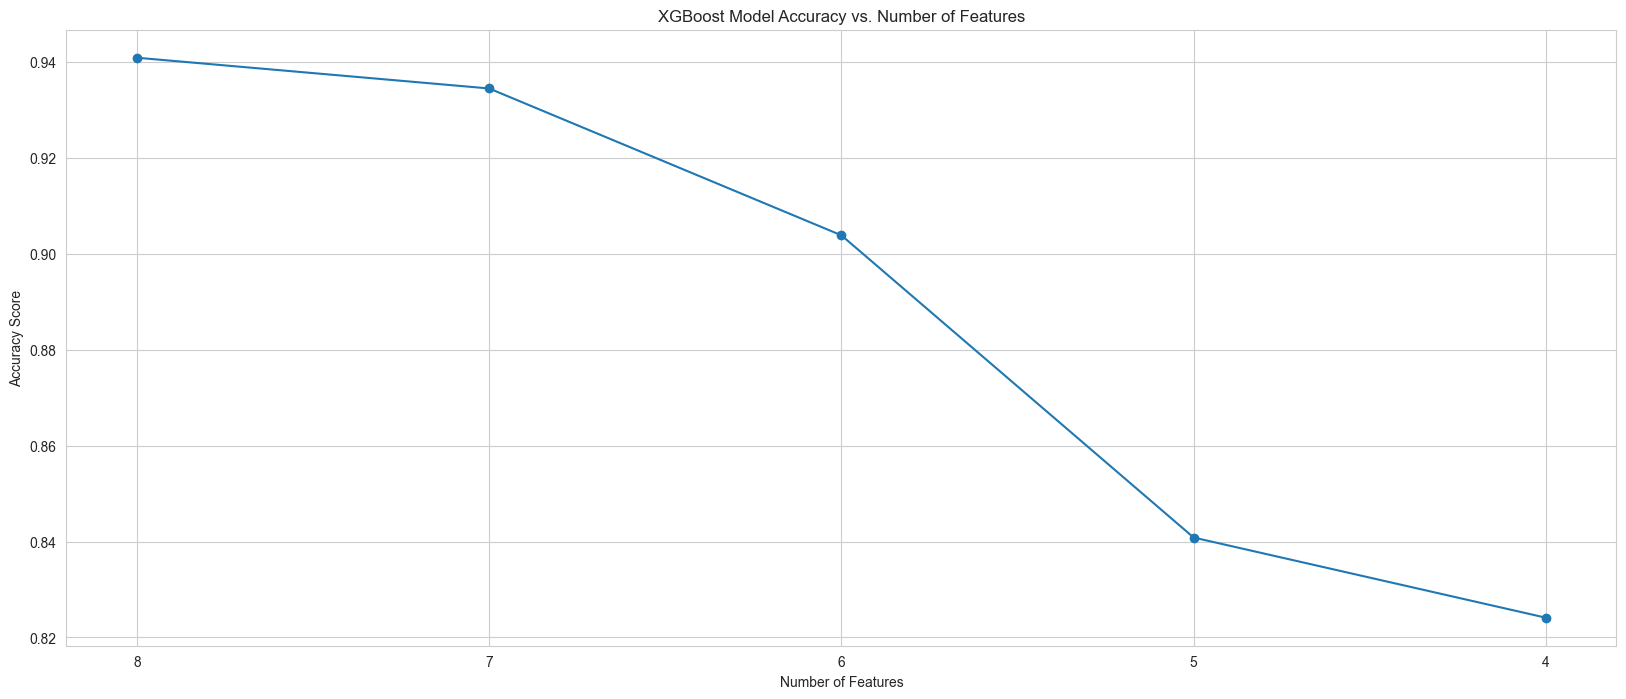

[0.9409106708376781,
 0.934499671725949,
 0.9038736338006411,
 0.8408450160274977,
 0.8241223496697949]

In [100]:
#Riprendiamo per comodità le nostre configurazioni iniziali (stesso codice). Per assicurarci della corretta esecuzione delle nuove funzioni. Iniziamo con xgboost_feature_reduction

y = df['satisfaction']

# X -> solo le 8 features più importanti per XGBoost
X = df[['Inflight wifi service', 'Age', 'Flight Distance', 'Type of Travel', 'Customer Type', 'Online boarding', 'Inflight service', 'Class']]

# Train e Test
train_test = StratifiedShuffleSplit(test_size = 0.2, n_splits = 1, random_state = 42)

for train_index, test_index in train_test.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
#Scaling (solo per X) lasciamo y integra. 
scaler = StandardScaler()
scld_X_train_xgb = scaler.fit_transform(X_train)
scld_X_test_xgb = scaler.transform(X_test)

# X_Train e X_test in Dataframe
scld_X_train_xgb = pd.DataFrame(scld_X_train_xgb, columns=X_train.columns)
scld_X_test_xgb = pd.DataFrame(scld_X_test_xgb, columns=X_test.columns)

# Dimensioni plot e stile
plt.figure(figsize=(20, 8))
sns.set_style("whitegrid")

xgboost_feature_reduction(scld_X_train_xgb, scld_X_test_xgb, y_train, y_test)

<Figure size 2000x800 with 0 Axes>

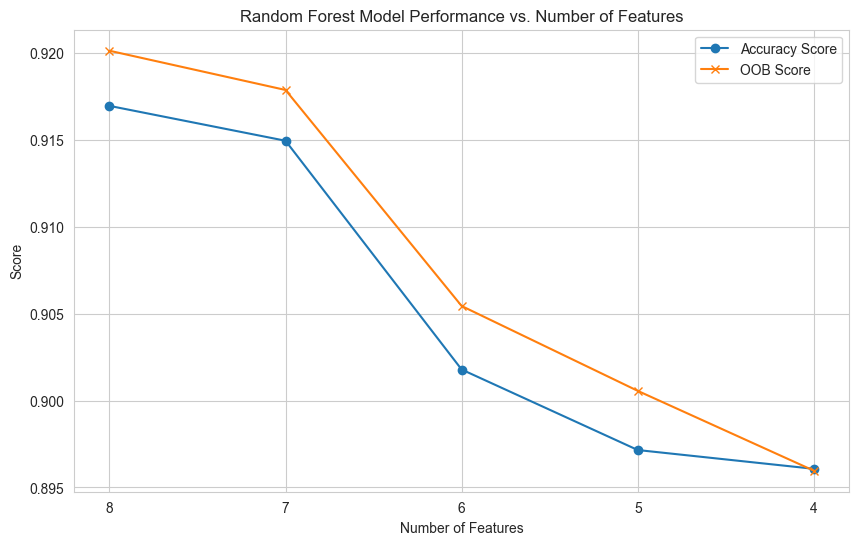

([0.9169659753601359,
  0.9149577105781486,
  0.9017881280655003,
  0.8971536708762986,
  0.8960722975321516],
 [0.9201401963908119,
  0.9178808330678099,
  0.9054446793924823,
  0.9005590475914608,
  0.8959630777549267])

In [101]:
# Adesso tocca random Forests

y = df['satisfaction']

# X -> solo le 8 features più importanti per Random Forests
X = df[['Online boarding', 'Inflight wifi service', 'Class', 'Type of Travel', 'Inflight entertainment', 'Seat comfort', 'Customer Type', 'Leg room service']]

# Train e Test
train_test = StratifiedShuffleSplit(test_size = 0.2, n_splits = 1, random_state = 42)

for train_index, test_index in train_test.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
#Scaling (solo per X) lasciamo y integra. 
scaler = StandardScaler()
scld_X_train_rnf = scaler.fit_transform(X_train)
scld_X_test_rnf = scaler.transform(X_test)

# X_Train e X_test in Dataframe
scld_X_train_rnf = pd.DataFrame(scld_X_train_rnf, columns=X_train.columns)
scld_X_test_rnf = pd.DataFrame(scld_X_test_rnf, columns=X_test.columns)

# Dimensioni plot e stile
plt.figure(figsize=(20, 8))
sns.set_style("whitegrid")

random_forests_feature_reduction(scld_X_train_rnf, scld_X_test_rnf, y_train, y_test)

XGBoost è il modello più solido, con 8 features. Abbiamo scelto 8 features perché ulteriori features contribuivano poco in termini di performance. Tuttavia, riducendo man mano le features possiamo notare come le performance di XGBoost calano nettamente mentre Random Forests mantiene il suo score oltre il 90%. Utilizzando 6 features Random Forest si rivela già il modello migliore. Utilizzando 5 features le performance di XGBoost calano a 84% di accuracy; Random Forests invece rimane oltre il 90% di accuracy, anche con 4 features.  

# Esperimenti (facoltativo)

KeyboardInterrupt: 

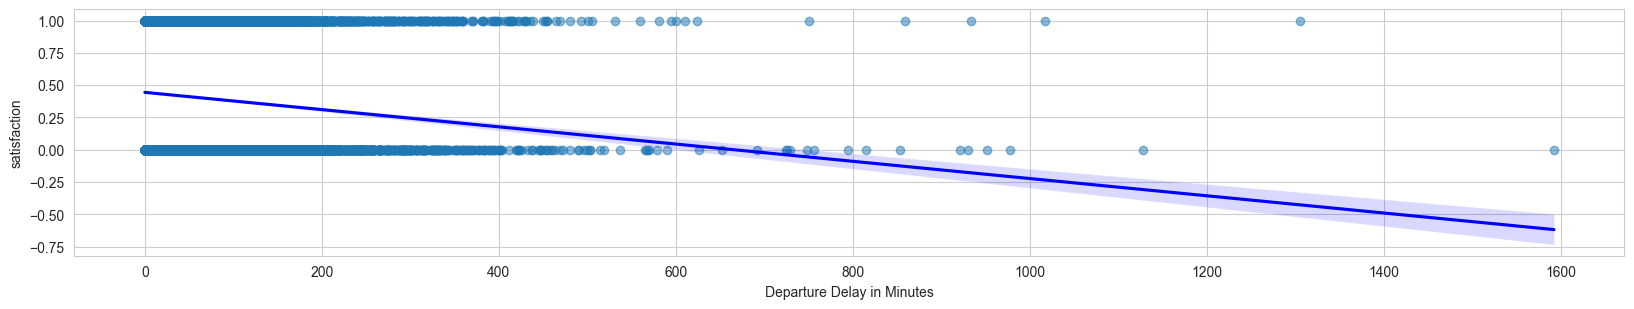

In [102]:
# Dimensioni plot e stile
plt.figure(figsize=(20, 8))
sns.set_style("whitegrid")
plt.subplots_adjust(wspace=0.5)
plt.subplots_adjust(hspace=0.5) # un po' di spazio tra il primo e il secondo plot


# Useremo l'attributo y_jitter. Senza y_jitter tutti i punti di satisfaction = 1 sarebbero esattamente allineati in orizzontale. 
# Quindi andrebbero a sovrapporsi, rendendo difficile vedere il numero effettivo di punti e la loro distribuzione lungo l'asse x. 
# Aggiungendo un po' di "y_itter" o rumore, i punti vengono leggermente spostati in alto e in basso in modo casuale, riducendo la sovrapposizione e migliorando la leggibilità.

# Primo subplot
plt.subplot(2, 1, 1)
# Regplot per il ritardo di partenza con LOWESS
sns.regplot(x='Departure Delay in Minutes', y='satisfaction', data=df_temp,
            scatter_kws={'alpha': 0.5}, line_kws={'color': 'blue'}) #, y_jitter=0.1)
# Regplot per il ritardo di partenza con regressione logistica
sns.regplot(x='Departure Delay in Minutes', y='satisfaction', data=df_temp, logistic=True,
                            scatter=False, line_kws={'color': 'red'})
plt.title('Departure Delay and Satisfaction with LOWESS and Logistic Regression')
plt.xlabel('Departure Delay (minutes)')
plt.ylabel('1=satisfied, 0=neutral or dissatisfied')

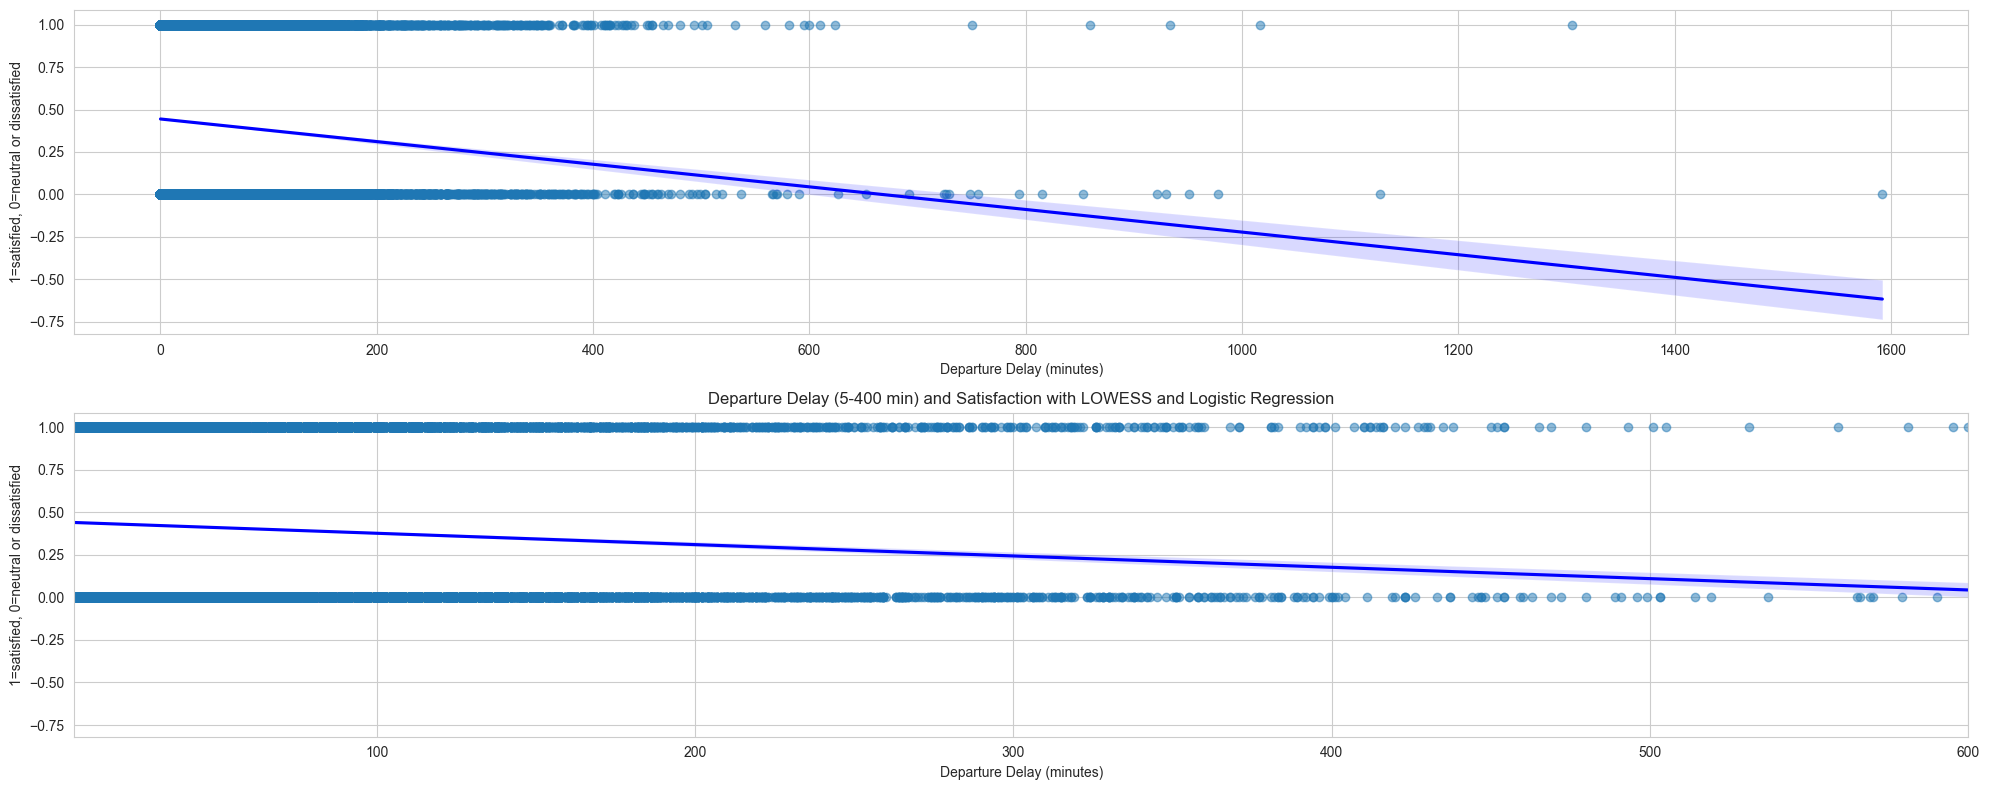

In [ ]:
# Dimensioni plot e stile
plt.figure(figsize=(20, 8))
sns.set_style("whitegrid")
plt.subplots_adjust(wspace=0.5)
plt.subplots_adjust(hspace=0.5) # un po' di spazio tra il primo e il secondo plot


# Useremo l'attributo y_jitter. Senza y_jitter tutti i punti di satisfaction = 1 sarebbero esattamente allineati in orizzontale. 
# Quindi andrebbero a sovrapporsi, rendendo difficile vedere il numero effettivo di punti e la loro distribuzione lungo l'asse x. 
# Aggiungendo un po' di "y_itter" o rumore, i punti vengono leggermente spostati in alto e in basso in modo casuale, riducendo la sovrapposizione e migliorando la leggibilità.

# Primo subplot
plt.subplot(2, 1, 1)
# Regplot per il ritardo di partenza con LOWESS
sns.regplot(x='Departure Delay in Minutes', y='satisfaction', data=df_temp,
            scatter_kws={'alpha': 0.5}, line_kws={'color': 'blue'}) #, y_jitter=0.1)
# Regplot per il ritardo di partenza con regressione logistica
plt.xlabel('Departure Delay (minutes)')
plt.ylabel('1=satisfied, 0=neutral or dissatisfied')

# Secondo subplot
plt.subplot(2, 1, 2)
# Regplot per il ritardo di partenza con LOWESS -> focus tra 5 minuti e 400 minuti
sns.regplot(x='Departure Delay in Minutes', y='satisfaction', data=df_temp,
            scatter_kws={'alpha': 0.5}, line_kws={'color': 'blue'}) #, y_jitter=0.1)
plt.xlim(5, 600)  # Imposta il limite sull'asse x da 5 a 400 minuti
# Regplot per il ritardo di partenza con regressione logistica -> focus tra 5 minuti e 400 minuti
plt.title('Departure Delay (5-400 min) and Satisfaction with LOWESS and Logistic Regression')
plt.xlabel('Departure Delay (minutes)')
plt.ylabel('1=satisfied, 0=neutral or dissatisfied')

# Visualizza il grafico
plt.tight_layout()
plt.show()

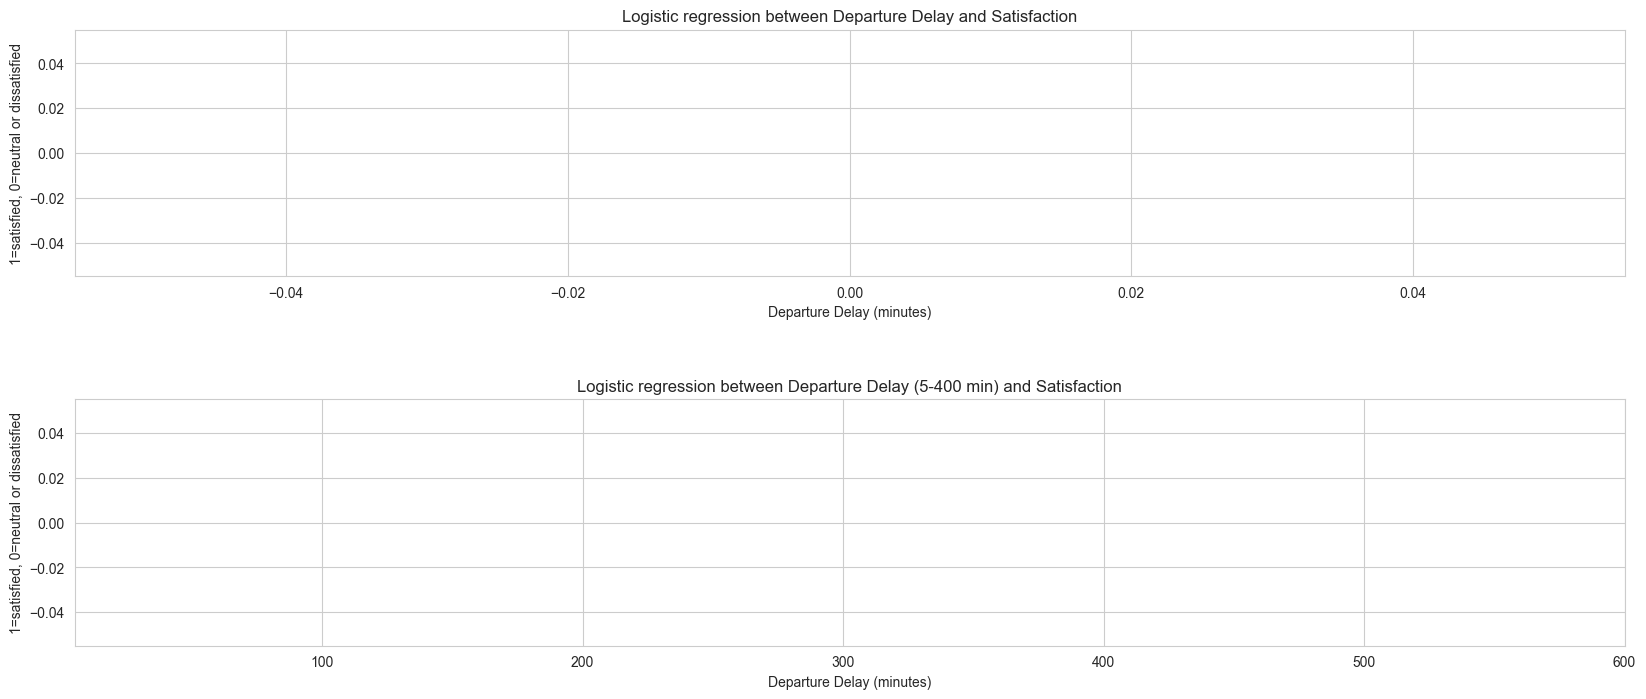

<Figure size 640x480 with 0 Axes>

In [ ]:
# Creiamo una copia temporanea del DataFrame per il plotting. 
# Poiche vogliamo fare una regressione logistica, ci serve che 'satisfaction' diventi non più una variabile categorica, ma numerica.
# Successivamente faremo l'encoding, quindi per comodità ci creiamo semplicemente una copia del df
df_temp = df.copy()

# Convertiamo la colonna 'satisfaction' in valori numerici nella copia temporanea
df_temp['satisfaction'] = df_temp['satisfaction'].map({'satisfied': 1, 'neutral or dissatisfied': 0})

# Dimensioni plot e stile
plt.figure(figsize=(20, 8))
sns.set_style("whitegrid")
plt.subplots_adjust(wspace=0.5)
plt.subplots_adjust(hspace=0.5) # un po di spazio tra il primo e il secondo plot

# Useremo l'attributo y_jitter. Senza y_jitter tutti i punti di satisfaction = 1 sarebbero esattamente allineati in orizzontale. 
# Quindi andrebbero a sovrapporsi, rendendo difficile vedere il numero effettivo di punti e la loro distribuzione lungo l'asse x. 
# Aggiungendo un po' di "y_itter" o rumore, i punti vengono leggermente spostati in alto e in basso in modo casuale, riducendo la sovrapposizione e migliorando la leggibilità.

# Primo subplot
plt.subplot(2, 1, 1)
# Regplot per il ritardo di partenza
sns.regplot(x='Departure Delay in Minutes', y='satisfaction', data=df_temp, logistic=True, y_jitter=.05)
plt.title('Logistic regression between Departure Delay and Satisfaction')
plt.xlabel('Departure Delay (minutes)')
plt.ylabel('1=satisfied, 0=neutral or dissatisfied')

# Secondo subplot
plt.subplot(2, 1, 2)
# Regplot per il ritardo di partenza -> focus tra 5 minuti e 400 (6 ore di ritardo)
sns.regplot(x='Departure Delay in Minutes', y='satisfaction', data=df_temp, logistic=True, y_jitter=.05)
plt.xlim(5, 600)  # Imposta il limite sull'asse x da 5 a 400 minuti
plt.title('Logistic regression between Departure Delay (5-400 min) and Satisfaction')
plt.xlabel('Departure Delay (minutes)')
plt.ylabel('1=satisfied, 0=neutral or dissatisfied')
plt.show()

# Visualizza il grafico
plt.tight_layout()
plt.show()

In [ ]:
#Caricamento file progetto 

#test_df = pd.read_csv(r"D:\Giorgio\Code\Project_NA_DataScience-\test.csv", encoding='cp1252')
#train_df = pd.read_csv(r"D:\Giorgio\Code\Project_NA_DataScience-\train.csv", encoding='cp1252')

In [ ]:
#Fai una visualizzazione con la PCA!

In [ ]:
# Grid search su XGBoost senza scaling

# Iper parametri base 
# xgb_classifier = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Definire la griglia di parametri
#param_grid = {
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 5, 10],
    'gamma': [0.5, 1, 1.5, 2],
    #'colsample_bytree': [0.6, 0.8, 1.0],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300]
}

# Impostare GridSearchCV
#grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, scoring='accuracy', cv=3, verbose=3)

# Adattare il modello
#grid_search.fit(X_train, y_train)

# Migliori parametri e punteggio
#print("Migliori parametri:", grid_search.best_params_)
#print("Miglior punteggio:", grid_search.best_score_)

IndentationError: unexpected indent (4250702403.py, line 8)

In [ ]:
# Miglior parametri gridsearch & XGBOOST con X senza scaling 
#model = xgb.XGBClassifier(objective='binary:logistic', gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=10, n_estimators=100, random_state=42)

In [ ]:
# Grid search su XGBoost con scaling

# Iper parametri base 
#xgb_classifier = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Definire la griglia di parametri
#param_grid = {
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 5, 10],
    'gamma': [0.5, 1, 1.5, 2],
    #'colsample_bytree': [0.6, 0.8, 1.0],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 500]
}

# Impostare GridSearchCV
#grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, scoring='accuracy', cv=3, verbose=3)

# Adattare il modello
#grid_search.fit(scld_X_train, y_train)

# Migliori parametri e punteggio
#print("Migliori parametri:", grid_search.best_params_)
#print("Miglior punteggio:", grid_search.best_score_)

Fitting 3 folds for each of 324 candidates, totalling 972 fits
[CV 1/3] END gamma=0.5, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100;, score=0.901 total time=   0.3s
[CV 2/3] END gamma=0.5, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100;, score=0.901 total time=   0.3s
[CV 3/3] END gamma=0.5, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100;, score=0.903 total time=   0.3s
[CV 1/3] END gamma=0.5, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=200;, score=0.911 total time=   0.6s
[CV 2/3] END gamma=0.5, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=200;, score=0.911 total time=   0.8s
[CV 3/3] END gamma=0.5, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=200;, score=0.914 total time=   0.6s
[CV 1/3] END gamma=0.5, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500;, score=0.934 total time=   1.7s
[CV 2/3] END gamma=0.5, learning_rate=0.01, max_

In [ ]:
# Miglior parametri gridsearch & XGBOOST con X senza scaling
#model = xgb.XGBClassifier(objective='binary:logistic', gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=300, random_state=42)

In [ ]:
# Grafico del modello con il numero ottimale di alberi
#model = xgb.XGBClassifier(objective='binary:logistic', gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=best_num_trees, random_state=42)
#model.fit(scld_X_train, y_train)

# adattare il codice per visualizzare i dati di test e le predizioni
#preds = model.predict(scld_X_test)
#plt.figure(figsize=(10, 5))
#plt.scatter(scld_X_test[:, 0], y_test, label='Actual data')  
#plt.plot(scld_X_test[:, 0], preds, color='red', label='Model predictions') 
#plt.xlabel('X1')
#plt.ylabel('y')
#plt.title('Best model (' + str(best_num_trees) + ' trees)')
#plt.legend()
#plt.show()

In [ ]:
def random_forests_feature_reduction(X_train, X_test, y_train, y_test):
    scores = []
    feature_list = X_train.columns.tolist()

    # Ciclo for che parte dal numero totale di features e si ferma a 4
    for num_features in range(len(feature_list), 3, -1):
        # Selezionare le features correnti
        current_features = feature_list[:num_features]
        X_train_reduced = X_train[current_features]
        X_test_reduced = X_test[current_features]
        
        # Inizializzazione e addestramento del modello Random Forest (con i nostri iper-parametri. Modificare eventualmente)
        model = RandomForestClassifier(max_depth=5, max_leaf_nodes=None, min_samples_split=6, n_estimators=500, random_state=42, oob_score=True)
        model.fit(X_train_reduced, y_train)
        
        # Valutazione del modello
        y_pred = model.predict(X_test_reduced)
        score = accuracy_score(y_test, y_pred)
        scores.append(score)
    
    # Creazione del plot
    #plt.figure(figsize=(10, 6))
    plt.plot(range(len(feature_list), 3, -1), scores, marker='o')
    plt.title('Random Forest Model Accuracy vs. Number of Features')
    plt.xlabel('Number of Features')
    plt.xticks(range(len(feature_list), 3, -1))
    plt.ylabel('Accuracy Score')
    plt.gca().invert_xaxis()  # Inverte l'asse X per mostrare il conteggio decrescente
    plt.grid(True)
    plt.show()
    
    return scores

In [ ]:
# Richiamo il df integro 
df

# X e y
X = df.drop('satisfaction',axis=1)
y = df['satisfaction']

# Train e Test
train_test = StratifiedShuffleSplit(test_size = 0.2, n_splits = 1, random_state = 42)

for train_index, test_index in train_test.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
#Scaling (solo per X) lasciamo y integra. 
scaler = StandardScaler()
scld_X_train = scaler.fit_transform(X_train)
scld_X_test = scaler.transform(X_test)

scld_X_train = pd.DataFrame(scld_X_train, columns=X_train.columns)
scld_X_test = pd.DataFrame(scld_X_test, columns=X_test.columns)

In [ ]:
# grid search di random forests, con x scaling 

# Iper parametri base
randomForests_classifier = RandomForestClassifier(random_state=42)

# Definire la griglia di parametri
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 4, 6],
    'max_leaf_nodes': [16, 32, None]
}

# Impostare GridSearchCV
grid_search = GridSearchCV(estimator=randomForests_classifier, param_grid=param_grid, cv=3, verbose=3)

# Adattare il modello
grid_search.fit(scld_X_train, y_train)

# Migliori parametri e punteggio
print("Migliori parametri:", grid_search.best_params_)
print("Miglior punteggio:", grid_search.best_score_)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV 1/3] END max_depth=3, max_leaf_nodes=16, min_samples_split=2, n_estimators=100;, score=0.886 total time=   2.1s
[CV 2/3] END max_depth=3, max_leaf_nodes=16, min_samples_split=2, n_estimators=100;, score=0.885 total time=   2.1s
[CV 3/3] END max_depth=3, max_leaf_nodes=16, min_samples_split=2, n_estimators=100;, score=0.888 total time=   2.1s
[CV 1/3] END max_depth=3, max_leaf_nodes=16, min_samples_split=2, n_estimators=200;, score=0.890 total time=   4.3s
[CV 2/3] END max_depth=3, max_leaf_nodes=16, min_samples_split=2, n_estimators=200;, score=0.889 total time=   4.3s
[CV 3/3] END max_depth=3, max_leaf_nodes=16, min_samples_split=2, n_estimators=200;, score=0.892 total time=   4.2s
[CV 1/3] END max_depth=3, max_leaf_nodes=16, min_samples_split=2, n_estimators=500;, score=0.895 total time=  12.3s
[CV 2/3] END max_depth=3, max_leaf_nodes=16, min_samples_split=2, n_estimators=500;, score=0.893 total time=  10.7s
[CV 3/3] 

In [ ]:
# Creazione validation set 


# Richiamo il df integro 
df

# X -> sole 8 features più importanti
#X = df[['Inflight wifi service', 'Age', 'Flight Distance', 'Type of Travel', 'Customer Type', 'Online boarding', 'Inflight service', 'Class']]
#y = df['satisfaction']

# Train e Test
##sss = StratifiedShuffleSplit(test_size=0.2, n_splits=1, random_state=42)
##train_index, test_index = next(sss.split(X, y))
#X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Seconda divisione per creare Train e Validation set
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=42)
# La proporzione è 0.25 perché stiamo prendendo il 25% dei dati di train per la validazione, che equivale al 20% del dataset originale.

# Scaling dei dati (solo per le X, y è già 'pulita')
#scaler = StandardScaler()
#scld_X_train = scaler.fit_transform(X_train)
#scld_X_val = scaler.transform(X_val)
#scld_X_test = scaler.transform(X_test)

[0]	validation_0-logloss:0.61673
[1]	validation_0-logloss:0.56146
[2]	validation_0-logloss:0.51527
[3]	validation_0-logloss:0.47644
[4]	validation_0-logloss:0.44314
[5]	validation_0-logloss:0.41458
[6]	validation_0-logloss:0.38988
[7]	validation_0-logloss:0.36838
[8]	validation_0-logloss:0.34939
[9]	validation_0-logloss:0.33290
[10]	validation_0-logloss:0.31838
[11]	validation_0-logloss:0.30570
[12]	validation_0-logloss:0.29389
[13]	validation_0-logloss:0.28087
[14]	validation_0-logloss:0.26980
[15]	validation_0-logloss:0.25983
[16]	validation_0-logloss:0.25103
[17]	validation_0-logloss:0.24336
[18]	validation_0-logloss:0.23642
[19]	validation_0-logloss:0.23032
[20]	validation_0-logloss:0.22488
[21]	validation_0-logloss:0.22006
[22]	validation_0-logloss:0.21537
[23]	validation_0-logloss:0.21111
[24]	validation_0-logloss:0.20729
[25]	validation_0-logloss:0.20393
[26]	validation_0-logloss:0.20091
[27]	validation_0-logloss:0.19738
[28]	validation_0-logloss:0.19507
[29]	validation_0-loglos

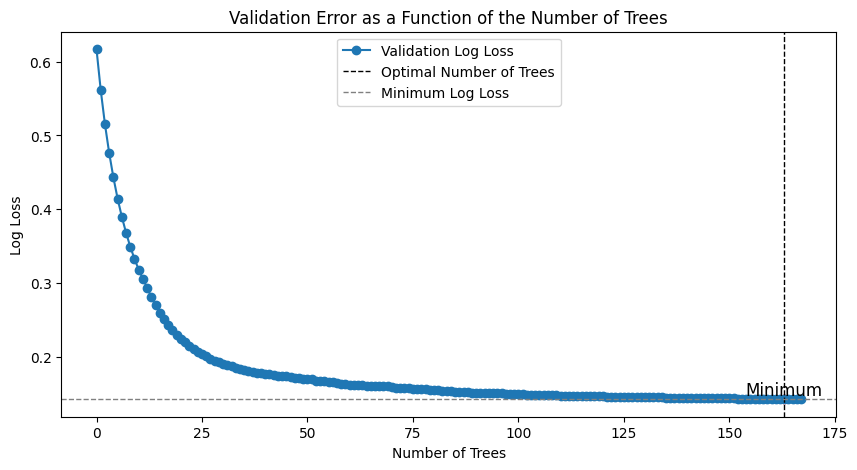

In [ ]:
# Dividiamo i dati di training per avere un validation set 
scld_X_train, scld_X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=49)

# Definisci e addestra il modello XGBoost con un set di valutazione e log_loss come metrica
model = xgb.XGBClassifier(objective='binary:logistic', gamma=0.5, learning_rate=0.1, 
                          max_depth=5, min_child_weight=5, n_estimators=300, random_state=42,
                          eval_metric='logloss')

# Addestra il modello utilizzando i dati di allenamento e valutalo sul set di test
eval_set = [(scld_X_val, y_val)]
model.fit(scld_X_train, y_train, eval_set=eval_set, early_stopping_rounds=5, verbose=True)

# Estrai i risultati di valutazione
results = model.evals_result()
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)

# Recupera gli errori di log loss dal dizionario dei risultati
errors = results['validation_0']['logloss']

# Trova il numero di estimatori che minimizza l'errore di log loss
bst_n_estimators = np.argmin(errors) + 1
min_error = np.min(errors)

# Crea il grafico
plt.figure(figsize=(10, 5))
plt.plot(x_axis, errors, label='Validation Log Loss', marker='o')
plt.axvline(x=bst_n_estimators, color='black', linestyle='dashed', linewidth=1, label='Optimal Number of Trees')
plt.axhline(y=min_error, color='grey', linestyle='dashed', linewidth=1, label='Minimum Log Loss')
plt.scatter(bst_n_estimators, min_error, color='red')  # Punto di errore minimo
plt.text(bst_n_estimators, min_error, 'Minimum', ha='center', va='bottom', fontsize=12)
plt.title('Validation Error as a Function of the Number of Trees')
plt.xlabel('Number of Trees')
plt.ylabel('Log Loss')
plt.legend()
plt.show()

<Figure size 2000x2000 with 0 Axes>

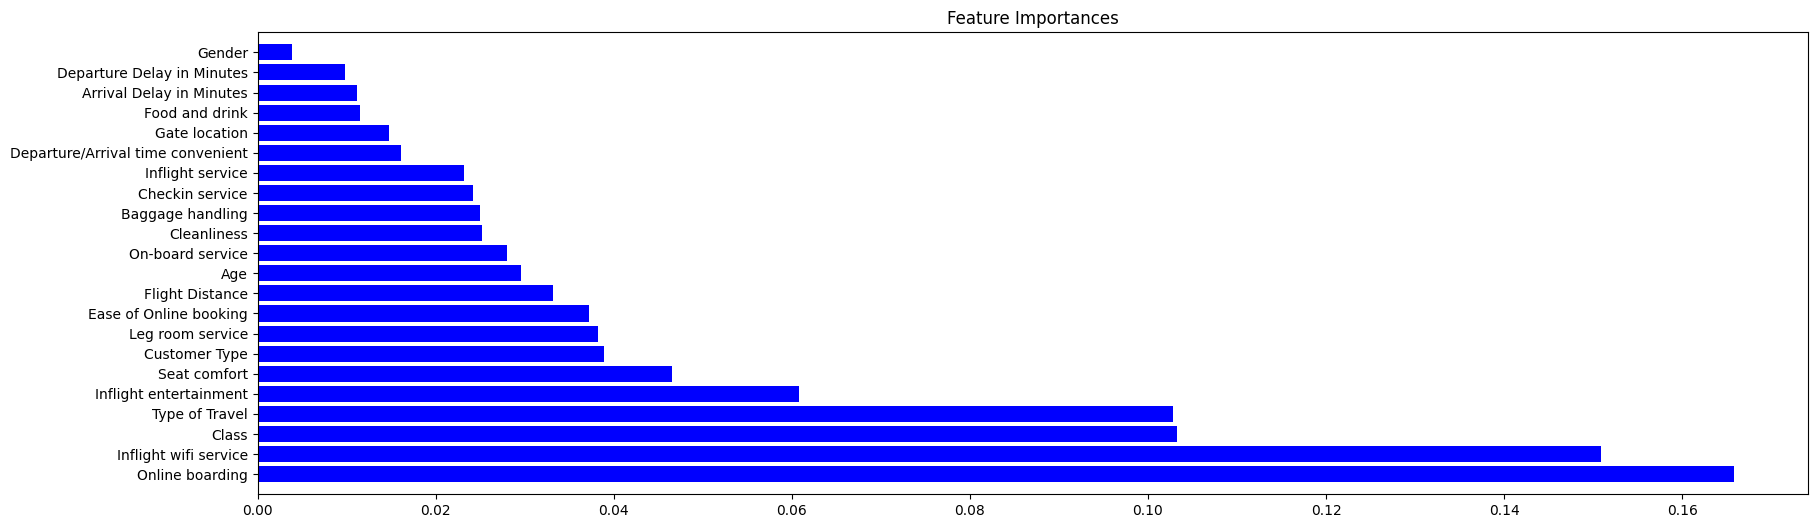

In [ ]:
# Dimensioni Plot
plt.figure(figsize=(20, 20))

# Ottieni gli indici delle feature in ordine di importanza
indices = np.argsort(feature_importances)[::-1]

# Nomina le feature se sono disponibili, altrimenti utilizza gli indici numerici
if hasattr(randomForests_classifier, 'feature_names_in_'):
    feature_names = randomForests_classifier.feature_names_in_[indices]
else:
    feature_names = np.array([f"Feature {i}" for i in range(len(feature_importances))])[indices]

# Seleziona il numero massimo di feature da plottare
max_num_features = min(len(feature_importances), 22)

# Crea il plot
plt.figure(figsize=(20, 6))
plt.title("Feature Importances")
plt.barh(range(max_num_features), feature_importances[indices[:max_num_features]], color='b', align='center')
plt.yticks(range(max_num_features), feature_names[:max_num_features])
plt.ylim([-1, max_num_features])
plt.show()

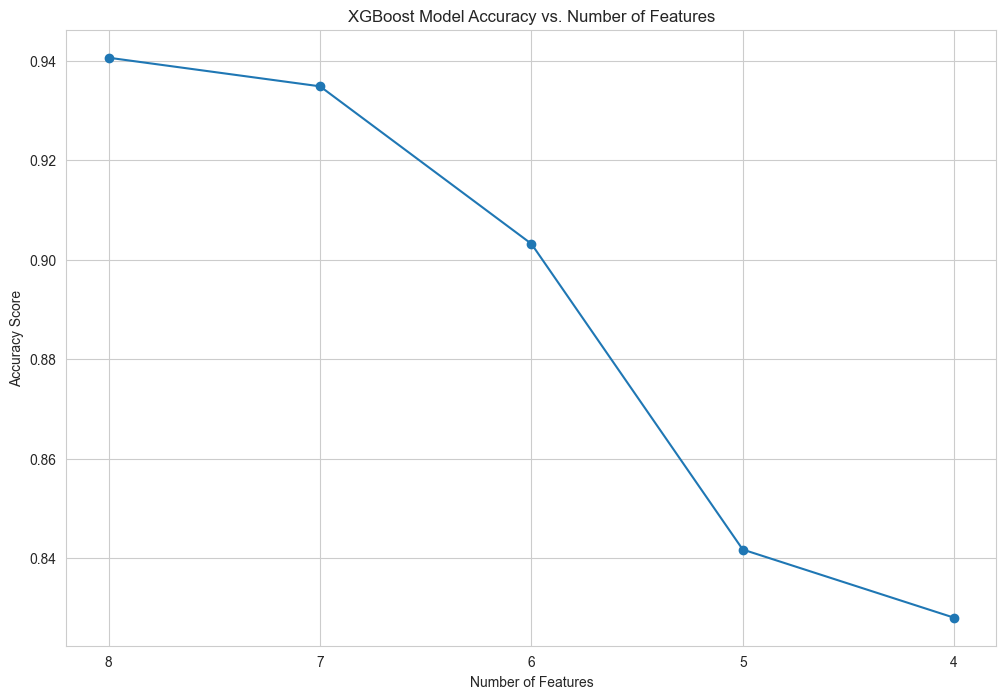

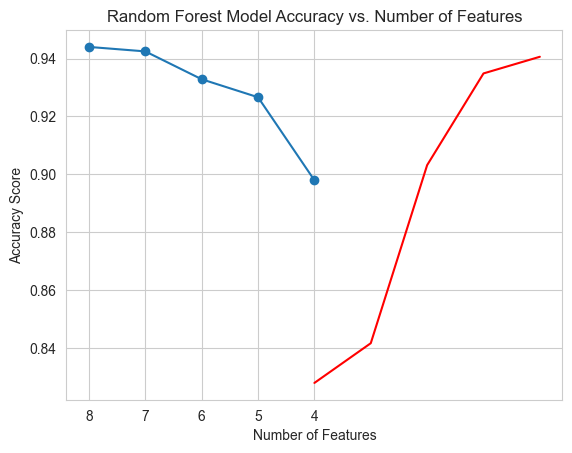

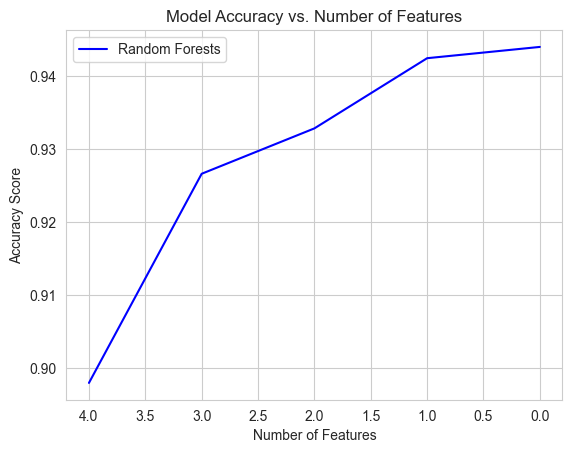

In [ ]:
# Chiamata delle funzioni e plottaggio dei risultati
plt.figure(figsize=(12, 8))
plt.plot(xgboost_feature_reduction(scld_X_train_xgb, scld_X_test_xgb, y_train, y_test), color='red', label='XGBoost')
plt.plot(random_forests_feature_reduction(scld_X_train_rnf, scld_X_test_rnf, y_train, y_test), color='blue', label='Random Forests')

# Impostazioni del grafico
plt.title('Model Accuracy vs. Number of Features')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy Score')
plt.legend()
plt.gca().invert_xaxis()  # Inverte l'asse X per mostrare il conteggio decrescente delle features
plt.grid(True)
plt.show()
